# TFG Eloy Celaya - Modelización

## Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import chi2
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

## Importar base de datos Kaggle

In [2]:
# Importar con API de kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alefernandezarmas/madrid-real-state-prices")

print("Path to dataset files:", path)

100%|██████████| 256k/256k [00:00<00:00, 589kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/alefernandezarmas/madrid-real-state-prices/versions/2


In [3]:
#Cargar dataset y ver info
df = pd.read_csv(f"{path}/buy_houses.csv", sep=";")
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14130 entries, 0 to 14129
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Address          14130 non-null  object 
 1   Zipcode          14125 non-null  float64
 2   Latitude         14130 non-null  float64
 3   Longitude        14130 non-null  float64
 4   Price            14130 non-null  int64  
 5   Date             14130 non-null  object 
 6   Rooms            14130 non-null  int64  
 7   Bathrooms        14130 non-null  int64  
 8   Surface          14130 non-null  int64  
 9   Floor            14130 non-null  int64  
 10  Elevator         14130 non-null  int64  
 11  Air_Conditioner  14130 non-null  int64  
 12  Heater           14130 non-null  int64  
 13  Parking          14130 non-null  int64  
 14  Balcony          14130 non-null  int64  
 15  Terrace          14130 non-null  int64  
 16  Swimming_Pool    14130 non-null  int64  
dtypes: float64(3

# Preproceso

Eliminar columnas irrelevantes

In [4]:
#ELiminar columna fecha
df = df.drop(columns=["Date"])
df = df.drop(columns=["Address"])

In [5]:
#Ver códigos postales nulos
df_bad_zip_1 = df[
    df["Zipcode"].isna()]

df_bad_zip_1[["Zipcode", "Latitude", "Longitude"]]

,Zipcode,Latitude,Longitude
3950,NaN,40.459030,-3.680462
4148,NaN,40.386154,-3.710279
4420,NaN,40.465656,-3.689630
5951,NaN,40.361073,-3.603503
7799,NaN,40.421010,-3.633303


In [6]:
#Ver códigos postales que no son de Madrid
df_bad_zip = df[
    df["Zipcode"].notna() &
    ((df["Zipcode"] < 28000) | (df["Zipcode"] >= 29000))]

df_bad_zip[["Zipcode", "Latitude", "Longitude"]]


,Zipcode,Latitude,Longitude
572,3189.0,40.464706,-3.747259
2078,43896.0,40.431860,-3.695687
2825,30001.0,40.416603,-3.701254
3206,45593.0,40.465057,-3.750407
3267,29600.0,40.459330,-3.676322
3349,45593.0,40.463100,-3.748824
3352,39728.0,40.464474,-3.747338
3493,33529.0,40.464565,-3.748333
3503,36780.0,40.464386,-3.750123
3577,39193.0,40.465530,-3.749319


In [7]:
#ELiminar columna de código postal
df = df.drop(columns=["Zipcode"])

Valores Nulos

In [8]:
nulos = df.isna().sum()
#Porcentaje de valores nulos
porc_nulos = (nulos / len(df)) * 100
porc_nulos

,0
Latitude,0.0
Longitude,0.0
Price,0.0
Rooms,0.0
Bathrooms,0.0
Surface,0.0
Floor,0.0
Elevator,0.0
Air_Conditioner,0.0
Heater,0.0


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14130 entries, 0 to 14129
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Latitude         14130 non-null  float64
 1   Longitude        14130 non-null  float64
 2   Price            14130 non-null  int64  
 3   Rooms            14130 non-null  int64  
 4   Bathrooms        14130 non-null  int64  
 5   Surface          14130 non-null  int64  
 6   Floor            14130 non-null  int64  
 7   Elevator         14130 non-null  int64  
 8   Air_Conditioner  14130 non-null  int64  
 9   Heater           14130 non-null  int64  
 10  Parking          14130 non-null  int64  
 11  Balcony          14130 non-null  int64  
 12  Terrace          14130 non-null  int64  
 13  Swimming_Pool    14130 non-null  int64  
dtypes: float64(2), int64(12)
memory usage: 1.5 MB


Exportar dataset para la web

In [10]:
#df.to_csv("modelos.csv", index=False)
#from google.colab import files
#files.download("modelos.csv")

# EDA univariante

### Variable objetivo

In [11]:
df[df["Price"] <= 1000].shape

(18, 14)

In [12]:
df[df["Price"] <= 1000].head(50)


,Latitude,Longitude,Price,Rooms,Bathrooms,Surface,Floor,Elevator,Air_Conditioner,Heater,Parking,Balcony,Terrace,Swimming_Pool
312,40.419456,-3.700168,0,4,5,235,10,1,1,1,0,0,0,0
538,40.485485,-3.667883,0,2,2,76,0,1,0,0,0,0,0,0
1376,40.423477,-3.725931,0,4,1,97,0,1,1,0,0,0,1,0
1756,40.422134,-3.722377,0,1,1,57,0,1,1,0,0,0,0,0
2477,40.372513,-3.743202,0,3,1,76,7,0,0,0,0,0,0,0
2548,40.438545,-3.717462,0,1,1,51,12,1,1,0,0,0,0,1
2768,40.420338,-3.717668,0,4,2,165,0,1,0,1,0,0,1,0
3281,40.385574,-3.704244,0,0,0,43,0,0,0,0,0,0,0,0
3328,40.437183,-3.698129,0,3,1,83,10,0,0,0,0,0,0,0
3344,40.463670,-3.749220,0,3,2,7,0,1,0,0,0,0,0,0


In [13]:
df = df[df["Price"] > 0]
print(df.describe())

           Latitude     Longitude         Price         Rooms     Bathrooms  \
count  14112.000000  14112.000000  1.411200e+04  14112.000000  14112.000000   
mean      40.411849     -3.687987  5.053584e+05      2.591766      1.734552   
std        0.590286      0.067450  6.185287e+05      1.285737      1.089621   
min        0.000000     -3.836437  2.500000e+04      0.000000      0.000000   
25%       40.394599     -3.709439  1.850000e+05      2.000000      1.000000   
50%       40.417547     -3.696392  3.090000e+05      2.000000      1.000000   
75%       40.438649     -3.668500  5.850000e+05      3.000000      2.000000   
max       40.531520      0.000000  1.950000e+07     33.000000     12.000000   

            Surface         Floor      Elevator  Air_Conditioner  \
count  14112.000000  14112.000000  14112.000000     14112.000000   
mean     103.580428      5.296910      0.662202         0.470096   
std       81.307013      3.896688      0.472976         0.499123   
min        0.000

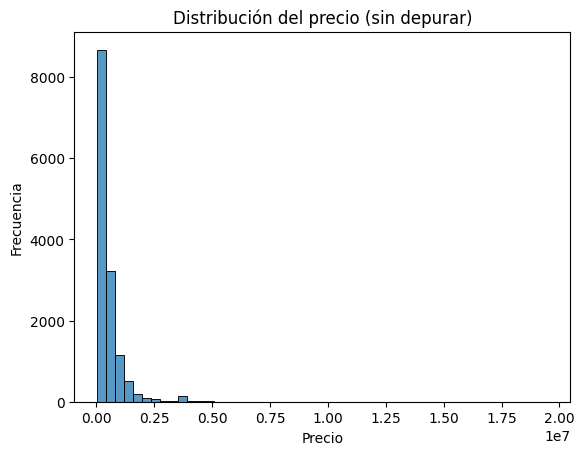

In [14]:
sns.histplot(df["Price"], bins=50)
plt.title("Distribución del precio (sin depurar)")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()


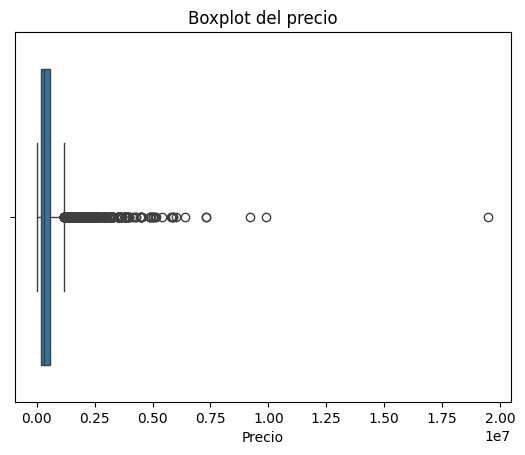

In [15]:
sns.boxplot(x=df["Price"])
plt.title("Boxplot del precio")
plt.xlabel("Precio")
plt.show()


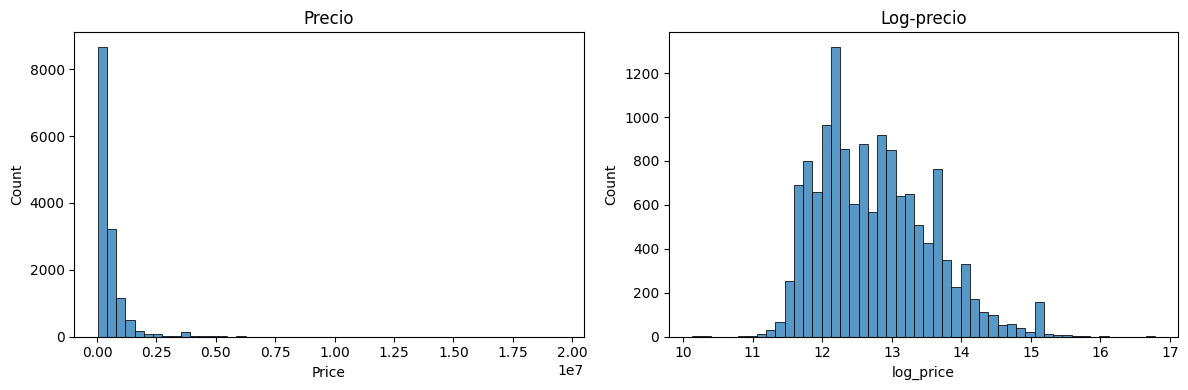

In [16]:
df["log_price"] = np.log(df["Price"])

fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(df["Price"], bins=50, ax=ax[0])
ax[0].set_title("Precio")

sns.histplot(df["log_price"], bins=50, ax=ax[1])
ax[1].set_title("Log-precio")

plt.tight_layout()
plt.show()


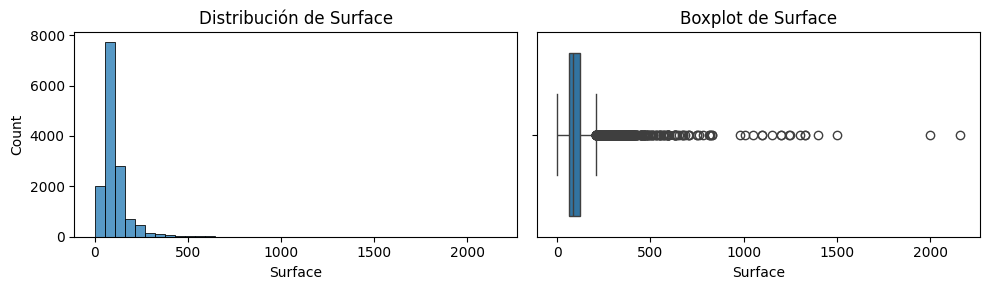

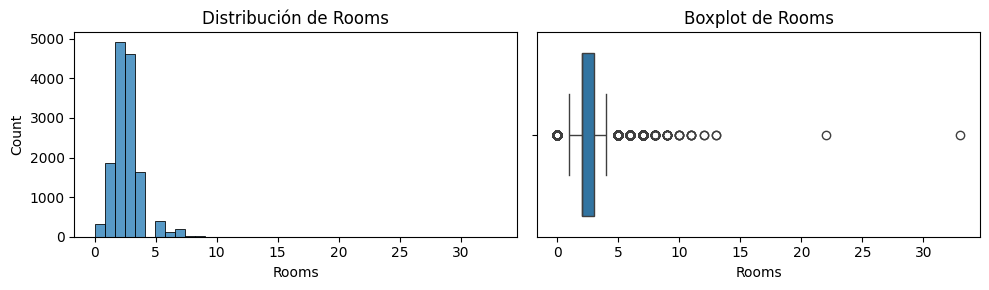

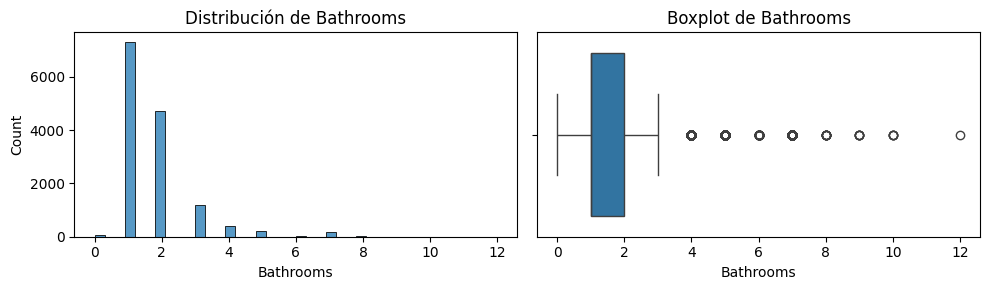

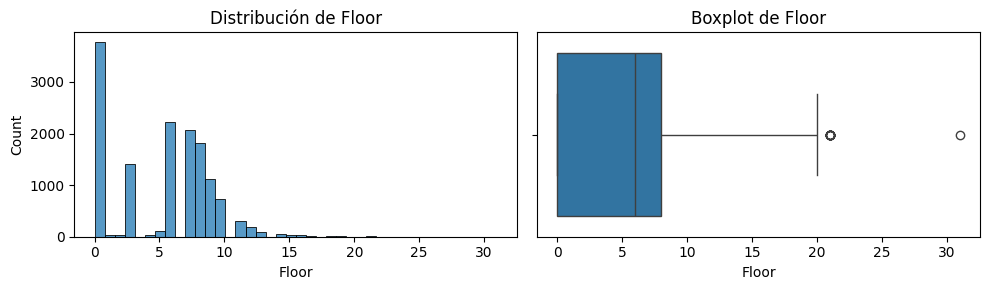

In [17]:
num_vars = ["Surface", "Rooms", "Bathrooms", "Floor"]

for var in num_vars:
    fig, ax = plt.subplots(1, 2, figsize=(10,3))

    sns.histplot(df[var], bins=40, ax=ax[0])
    ax[0].set_title(f"Distribución de {var}")

    sns.boxplot(x=df[var], ax=ax[1])
    ax[1].set_title(f"Boxplot de {var}")

    plt.tight_layout()
    plt.show()


In [18]:
#Superficies muy pequeñas (errores)
df[df["Surface"] <= 10].head(50)

,Latitude,Longitude,Price,Rooms,Bathrooms,Surface,Floor,Elevator,Air_Conditioner,Heater,Parking,Balcony,Terrace,Swimming_Pool,log_price
799,40.458412,-3.707532,175000,2,2,0,0,0,1,0,0,0,0,0,12.072541
1398,40.374733,-3.741880,142000,2,1,0,7,0,1,0,0,0,1,0,11.863582
2074,40.410250,-3.705667,390000,3,2,0,0,0,0,0,0,0,0,0,12.873902
3316,40.476215,-3.639171,220000,3,1,3,6,0,0,0,0,0,1,0,12.301383
3495,40.465466,-3.748698,550000,3,3,1,0,0,0,0,0,0,0,0,13.217674
3626,40.477600,-3.705156,190400,2,1,1,6,0,1,0,0,0,0,0,12.156882
9869,40.415490,-3.668665,25000,1,1,10,1,0,0,0,0,0,0,0,10.126631


In [19]:
#ELiminar superficies menores de 10
df = df[df["Surface"] > 9]

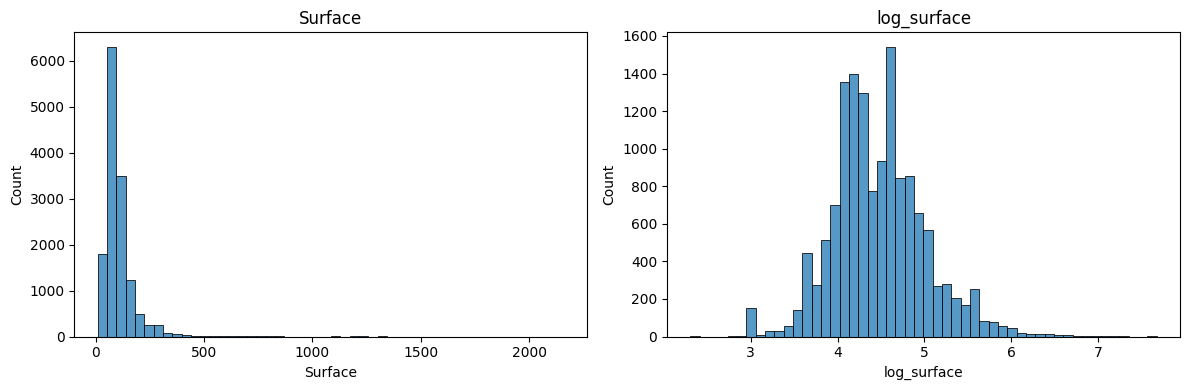

In [20]:
df["log_surface"] = np.log(df["Surface"])

fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(df["Surface"], bins=50, ax=ax[0])
ax[0].set_title("Surface")

sns.histplot(df["log_surface"], bins=50, ax=ax[1])
ax[1].set_title("log_surface")

plt.tight_layout()
plt.show()


### Localización

In [21]:
#Todo 0
df[(df["Latitude"] == 0) & (df["Longitude"] == 0)]

,Latitude,Longitude,Price,Rooms,Bathrooms,Surface,Floor,Elevator,Air_Conditioner,Heater,Parking,Balcony,Terrace,Swimming_Pool,log_price,log_surface
4821,0.0,0.0,233000,1,1,55,0,1,0,1,0,0,0,0,12.358794,4.007333
5261,0.0,0.0,485000,3,1,180,0,0,1,1,1,0,0,0,13.091904,5.192957
5484,0.0,0.0,1150000,5,3,172,0,1,1,1,1,0,1,0,13.955273,5.147494


In [22]:
#Eliminar las entradas con 0
df = df[~((df["Latitude"] == 0) & (df["Longitude"] == 0))]

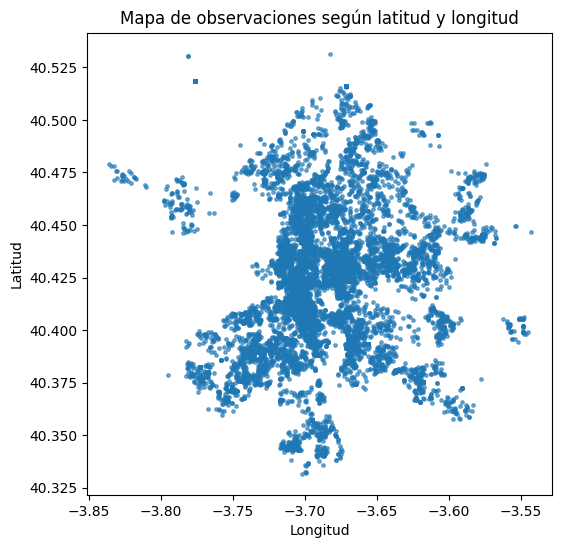

In [23]:
plt.figure(figsize=(6,6))
plt.scatter(
    df["Longitude"],
    df["Latitude"],
    s=6,
    alpha=0.6)

plt.title("Mapa de observaciones según latitud y longitud")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


# EDA bivariante

### Variables numéricas

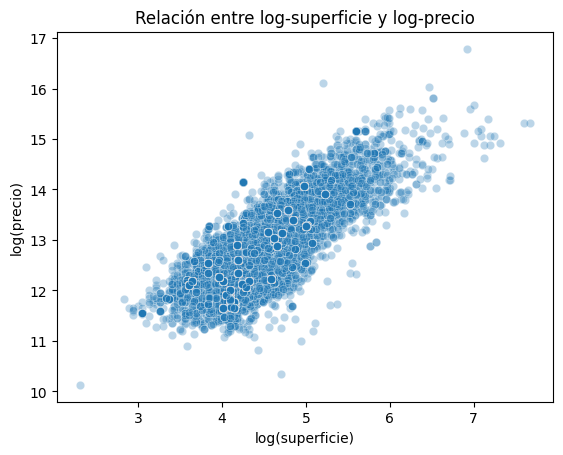

In [25]:
sns.scatterplot(
    x="log_surface",
    y="log_price",
    data=df,
    alpha=0.3)

plt.title("Relación entre log-superficie y log-precio")
plt.xlabel("log(superficie)")
plt.ylabel("log(precio)")
plt.show()


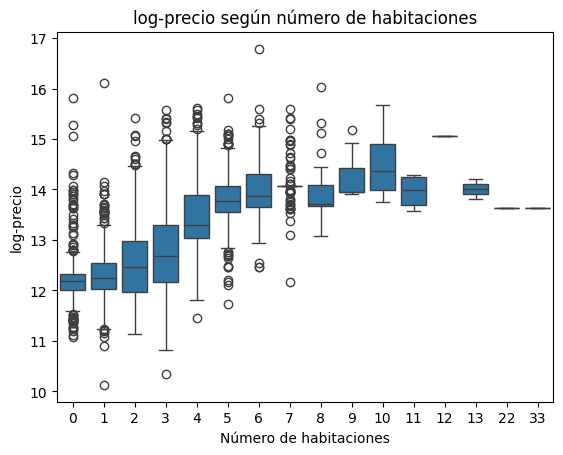

In [26]:
sns.boxplot(x="Rooms", y="log_price", data=df)
plt.title("log-precio según número de habitaciones")
plt.xlabel("Número de habitaciones")
plt.ylabel("log-precio")
plt.show()


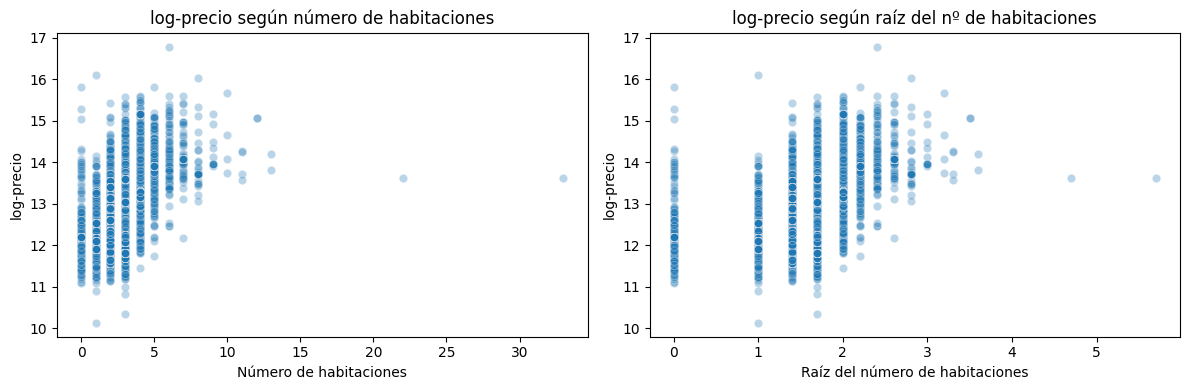

In [27]:
df["sqrt_habitaciones"] = np.sqrt(df["Rooms"]).round(1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(
    x="Rooms",
    y="log_price",
    data=df,
    alpha=0.3,
    ax=ax[0]
)
ax[0].set_title("log-precio según número de habitaciones")
ax[0].set_xlabel("Número de habitaciones")
ax[0].set_ylabel("log-precio")

sns.scatterplot(
    x="sqrt_habitaciones",
    y="log_price",
    data=df,
    alpha=0.3,
    ax=ax[1]
)
ax[1].set_title("log-precio según raíz del nº de habitaciones")
ax[1].set_xlabel("Raíz del número de habitaciones")
ax[1].set_ylabel("log-precio")

plt.tight_layout()
plt.show()



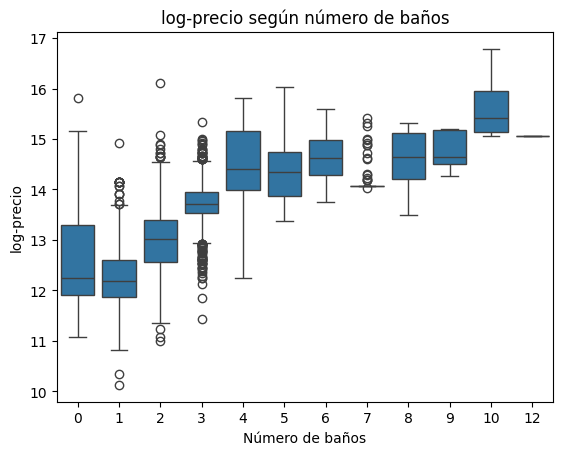

In [28]:
sns.boxplot(x="Bathrooms", y="log_price", data=df)
plt.title("log-precio según número de baños")
plt.xlabel("Número de baños")
plt.ylabel("log-precio")
plt.show()


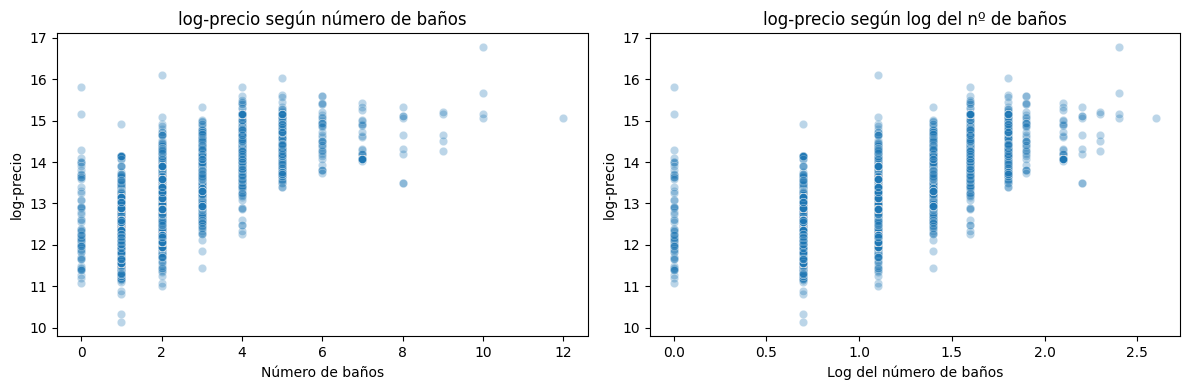

In [29]:
df["log_Bathrooms"] = np.log1p(df["Bathrooms"]).round(1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(
    x="Bathrooms",
    y="log_price",
    data=df,
    alpha=0.3,
    ax=ax[0])
ax[0].set_title("log-precio según número de baños")
ax[0].set_xlabel("Número de baños")
ax[0].set_ylabel("log-precio")

sns.scatterplot(
    x="log_Bathrooms",
    y="log_price",
    data=df,
    alpha=0.3,
    ax=ax[1])
ax[1].set_title("log-precio según log del nº de baños")
ax[1].set_xlabel("Log del número de baños")
ax[1].set_ylabel("log-precio")

plt.tight_layout()
plt.show()

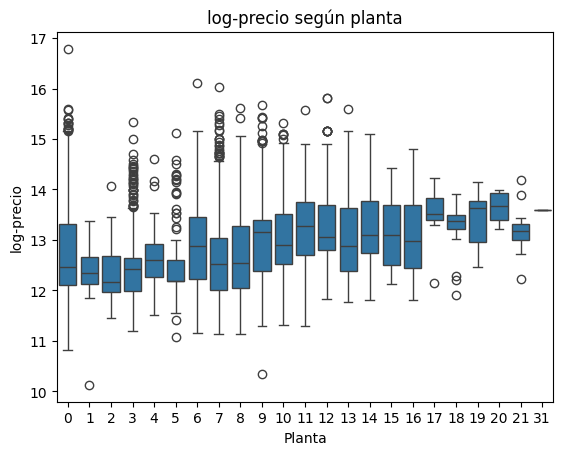

In [30]:
sns.boxplot(x="Floor", y="log_price", data=df)
plt.title("log-precio según planta")
plt.xlabel("Planta")
plt.ylabel("log-precio")
plt.show()


### Variables binarias

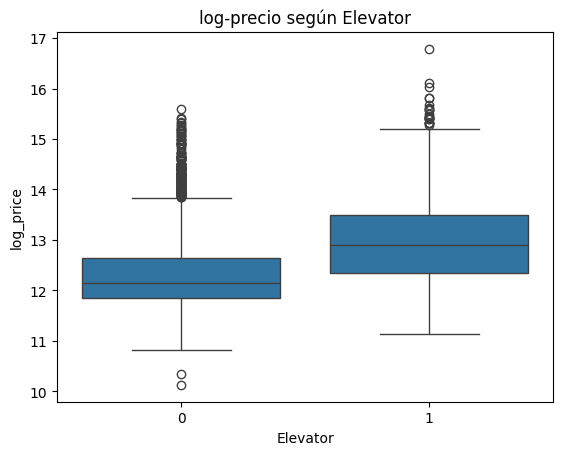

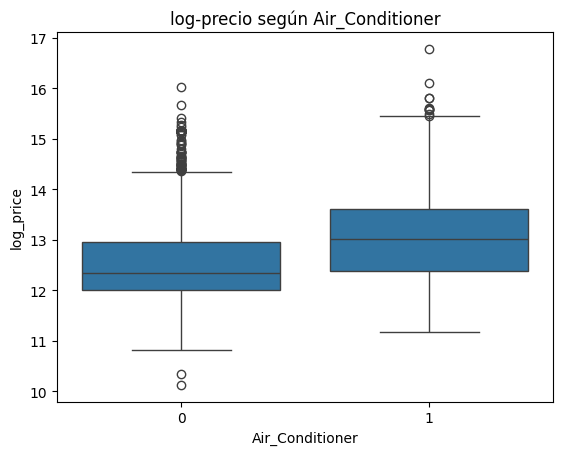

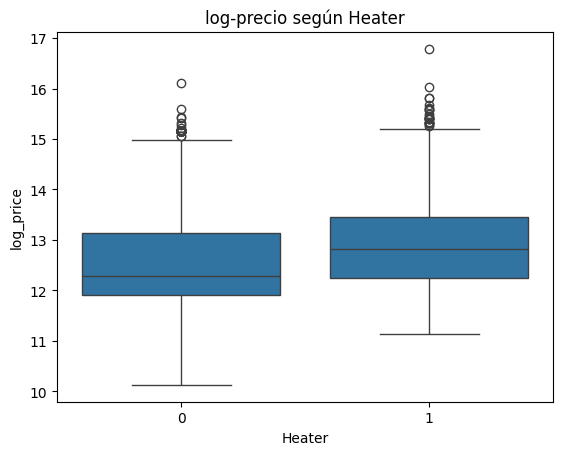

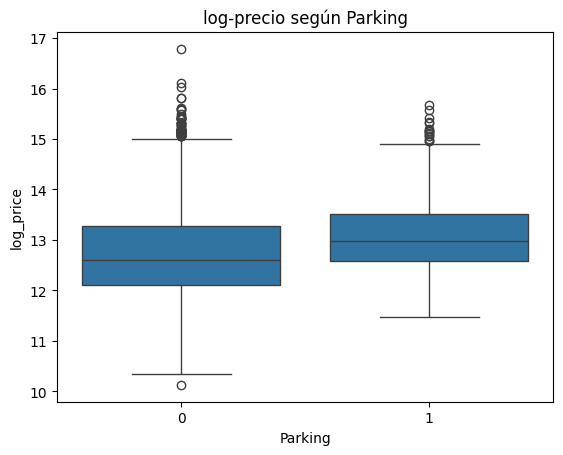

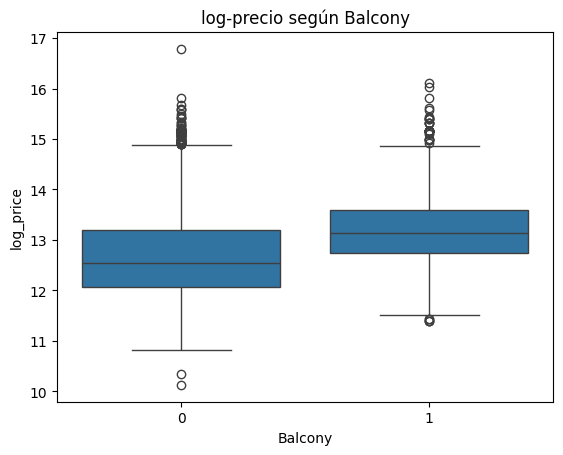

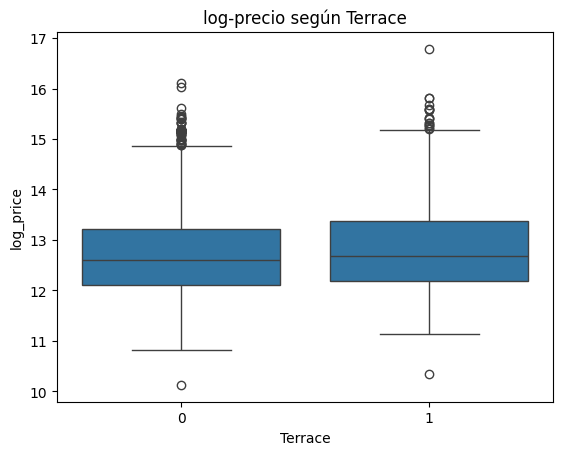

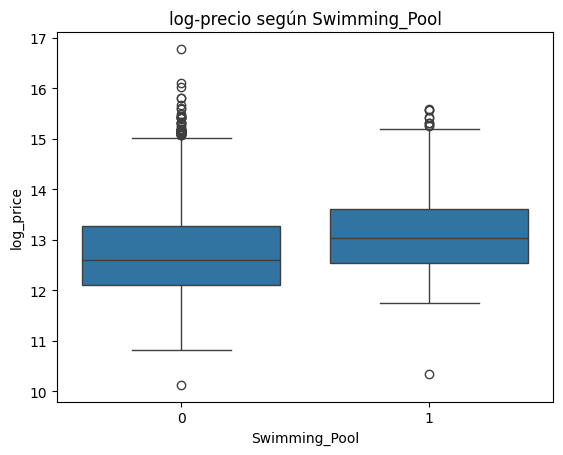

In [31]:
binary_vars = [
    "Elevator", "Air_Conditioner", "Heater",
    "Parking", "Balcony", "Terrace", "Swimming_Pool"]

for var in binary_vars:
    sns.boxplot(x=var, y="log_price", data=df)
    plt.title(f"log-precio según {var}")
    plt.show()


In [32]:
from scipy.stats import mannwhitneyu # Se tienen distribuciones, dispersiones y asimetrias similares.

results = []

for var in binary_vars:
    group0 = df.loc[df[var] == 0, "log_price"].dropna()
    group1 = df.loc[df[var] == 1, "log_price"].dropna()

    stat, pvalue = mannwhitneyu(
        group0,
        group1,
        alternative="two-sided")

    results.append({
        "variable": var,
        "n_0": len(group0),
        "n_1": len(group1),
        "median_0": group0.median(),
        "median_1": group1.median(),
        "U": stat,
        "p_value": pvalue})

results_df = pd.DataFrame(results)
results_df


,variable,n_0,n_1,median_0,median_1,U,p_value
0,Elevator,4760,9343,12.149502,12.898970,11228291.5,0.000000e+00
1,Air_Conditioner,7474,6629,12.345835,13.017003,15280457.0,0.000000e+00
2,Heater,5545,8558,12.278393,12.821258,17148464.5,8.966403e-171
3,Parking,13128,975,12.604849,12.987688,4571957.0,3.120353e-50
4,Balcony,11785,2318,12.542545,13.132314,8725790.0,7.452099e-167
5,Terrace,9584,4519,12.611538,12.676076,20045455.0,9.725966e-13
6,Swimming_Pool,13067,1036,12.604849,13.036805,4778544.0,4.408433e-56


### Variables de localización (lat y lon)

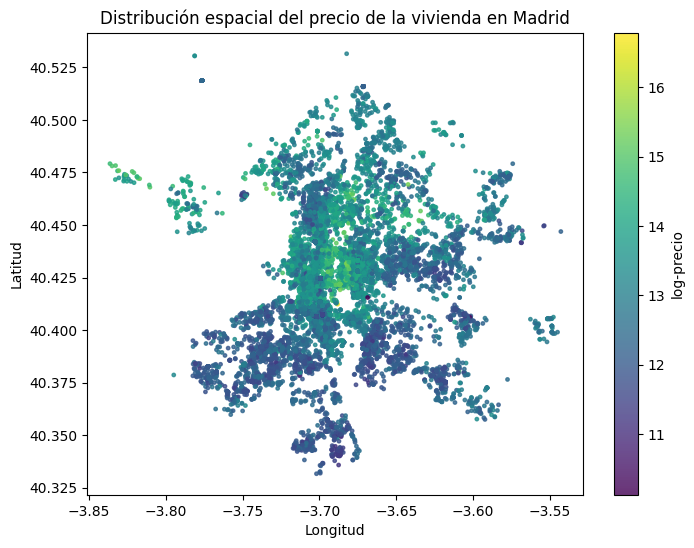

In [34]:
plt.figure(figsize=(8,6))
plt.scatter(
    df["Longitude"], df["Latitude"],
    c=df["log_price"], cmap="viridis", s=6, alpha=0.8)

plt.colorbar(label="log-precio")
plt.title("Distribución espacial del precio de la vivienda en Madrid")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


### Matriz de correlaciones (solo variables numéricas)

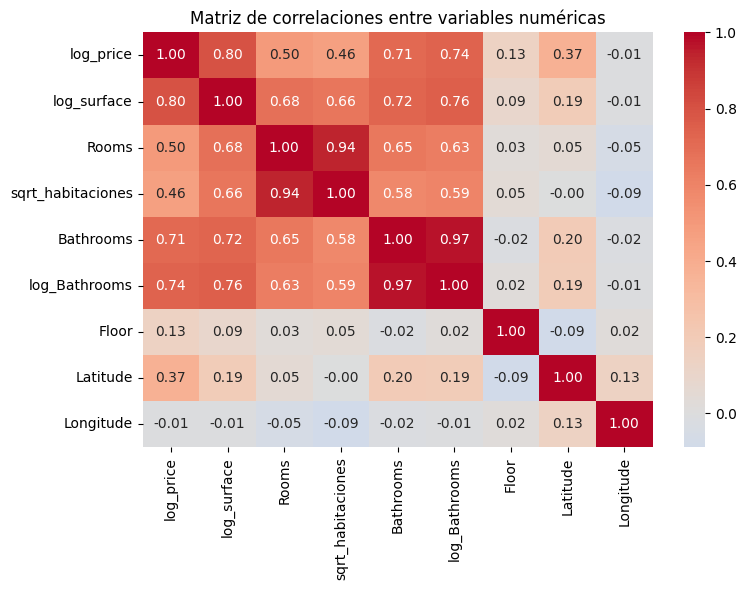

In [35]:
corr_vars = [
    "log_price",
    "log_surface",
    "Rooms",
    "sqrt_habitaciones",
    "Bathrooms",
    "log_Bathrooms",
    "Floor",
    "Latitude",
    "Longitude"]

corr = df[corr_vars].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0)

plt.title("Matriz de correlaciones entre variables numéricas")
plt.tight_layout()
plt.show()


### tabla de Variables finales

In [36]:
variables_finales = pd.DataFrame({
    "Variable": [
        "log_price",
        "log_surface",
        "Rooms",
        "sqrt_habitaciones",
        "Bathrooms",
        "log_Bathrooms",
        "Floor",
        "Latitude",
        "Longitude",
        "Elevator",
        "Air_Conditioner",
        "Heater",
        "Parking",
        "Balcony",
        "Terrace",
        "Swimming_Pool"],

    "Tipo": [
        "Numérica (objetivo)",
        "Numérica",
        "Numérica",
        "Numérica",
        "Numérica",
        "Numérica",
        "Numérica",
        "Numérica",
        "Numérica",
        "Binaria",
        "Binaria",
        "Binaria",
        "Binaria",
        "Binaria",
        "Binaria",
        "Binaria"],

    "Descripción": [
        "Logaritmo del precio de la vivienda",
        "Logaritmo de la superficie construida",
        "Número de habitaciones",
        "Raíz del número de habitaciones",
        "Número de baños",
        "Logaritmo del número de baños",
        "Planta del inmueble",
        "Latitud geográfica",
        "Longitud geográfica",
        "Presencia de ascensor",
        "Presencia de aire acondicionado",
        "Sistema de calefacción",
        "Plaza de aparcamiento",
        "Presencia de balcón",
        "Presencia de terraza",
        "Presencia de piscina"]})

variables_finales


,Variable,Tipo,Descripción
0,log_price,Numérica (objetivo),Logaritmo del precio de la vivienda
1,log_surface,Numérica,Logaritmo de la superficie construida
2,Rooms,Numérica,Número de habitaciones
3,sqrt_habitaciones,Numérica,Raíz del número de habitaciones
4,Bathrooms,Numérica,Número de baños
5,log_Bathrooms,Numérica,Logaritmo del número de baños
6,Floor,Numérica,Planta del inmueble
7,Latitude,Numérica,Latitud geográfica
8,Longitude,Numérica,Longitud geográfica
9,Elevator,Binaria,Presencia de ascensor


Exportar df final para web

In [37]:
#df.to_csv("modelos_final.csv", index=False)
#from google.colab import files
#files.download("modelos_final.csv")

# Preproceso final para los modelos

### División en train y set

In [38]:
df.shape

(14103, 18)

In [39]:
#Eliminar price y surface
df = df.drop(columns=["Price", "Surface"])

In [40]:
#X con variables Rooms y Bathrooms sin transformar
X = df.drop(columns=["log_price","sqrt_habitaciones","log_Bathrooms"])
y = df["log_price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

In [41]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (8461, 13)
Shape of X_test: (5642, 13)
Shape of y_train: (8461,)
Shape of y_test: (5642,)


In [42]:
#X con transformaciones, y es igual
X_transformed = df.drop(columns=["log_price", "Rooms", "Bathrooms"])

X_train_t, X_test_t, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.4, random_state=42)

In [43]:
num_vars = ["log_surface", "Rooms", "Bathrooms", "Floor", "Latitude", "Longitude"]
num_vars_t = ["log_surface", "sqrt_habitaciones", "log_Bathrooms", "Floor", "Latitude", "Longitude"]
bin_vars = ["Elevator", "Air_Conditioner", "Heater", "Parking",
            "Balcony", "Terrace", "Swimming_Pool"]

In [44]:
preprocess_scaled = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_vars),
        ("bin", "passthrough", bin_vars)])

In [45]:
preprocess_scaled_tranformed = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_vars_t),
        ("bin", "passthrough", bin_vars)])

In [46]:
preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_vars),
        ("bin", "passthrough", bin_vars)])


# Modelos

## Regresión Lineal

In [47]:
#Pipeline: preprocesamiento + modelo
pipe_lm = Pipeline(steps=[
    ("preprocess", preprocess_scaled),
    ("model", LinearRegression())])

#Ajustar modelo
pipe_lm.fit(X_train, y_train)

#Predicciones
y_train_pred = pipe_lm.predict(X_train)
y_test_pred = pipe_lm.predict(X_test)

#Métricas
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

#Display the results
print(f"Training RMSE: {rmse_train:.4f}")
print(f"Testing RMSE: {rmse_test:.4f}")
print(f"Training R²: {r2_train:.4f}")
print(f"Testing R²: {r2_test:.4f}")

Training RMSE: 0.3790
Testing RMSE: 0.3743
Training R²: 0.7789
Testing R²: 0.7817


In [48]:
#Pipeline: preprocesamiento + modelo (con transformaciones)
pipe_lm_t = Pipeline(steps=[
    ("preprocess", preprocess_scaled_tranformed),
    ("model", LinearRegression())])

#Ajustar modelo
pipe_lm_t.fit(X_train_t, y_train)

#Predicciones
y_train_pred_t = pipe_lm_t.predict(X_train_t)
y_test_pred_t = pipe_lm_t.predict(X_test_t)

#Métricas
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_t))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_t))
r2_train = r2_score(y_train, y_train_pred_t)
r2_test = r2_score(y_test, y_test_pred_t)

#Display the results
print(f"Training RMSE: {rmse_train:.4f}")
print(f"Testing RMSE: {rmse_test:.4f}")
print(f"Training R²: {r2_train:.4f}")
print(f"Testing R²: {r2_test:.4f}")

Training RMSE: 0.3779
Testing RMSE: 0.3733
Training R²: 0.7803
Testing R²: 0.7828


Importancia variables sin transformaciones

In [49]:
#Obtener nombres de variables tras el preprocesamiento
feature_names = (preprocess_scaled.get_feature_names_out())

#Extraer coeficientes
coefs = pipe_lm.named_steps["model"].coef_

coef_table = (
    pd.DataFrame({
        "Variable": feature_names,
        "Coeficiente": coefs})
    .sort_values(by="Coeficiente", key=np.abs, ascending=False))

coef_table


,Variable,Coeficiente
0,num__log_surface,0.467608
2,num__Bathrooms,0.246767
6,bin__Elevator,0.198448
10,bin__Balcony,0.182156
11,bin__Terrace,-0.174782
4,num__Latitude,0.162638
12,bin__Swimming_Pool,-0.110405
1,num__Rooms,-0.093476
7,bin__Air_Conditioner,0.083185
3,num__Floor,0.068329


Importancia variables con transformaciones

In [50]:
#Obtener nombres de variables tras el preprocesamiento
feature_names_t = (preprocess_scaled_tranformed.get_feature_names_out())

#Extraer coeficientes
coefs = pipe_lm_t.named_steps["model"].coef_

coef_table = (
    pd.DataFrame({
        "Variable": feature_names_t,
        "Coeficiente": coefs})
    .sort_values(by="Coeficiente", key=np.abs, ascending=False))

coef_table

,Variable,Coeficiente
0,num__log_surface,0.456385
2,num__log_Bathrooms,0.251056
6,bin__Elevator,0.188397
11,bin__Terrace,-0.184599
10,bin__Balcony,0.174875
4,num__Latitude,0.163366
12,bin__Swimming_Pool,-0.122240
1,num__sqrt_habitaciones,-0.088228
7,bin__Air_Conditioner,0.082843
9,bin__Parking,-0.065317


In [51]:
y_train_pred = pipe_lm.predict(X_train)
residuals = y_train - y_train_pred

y_train_pred_t = pipe_lm_t.predict(X_train_t)
residuals_t = y_train - y_train_pred_t

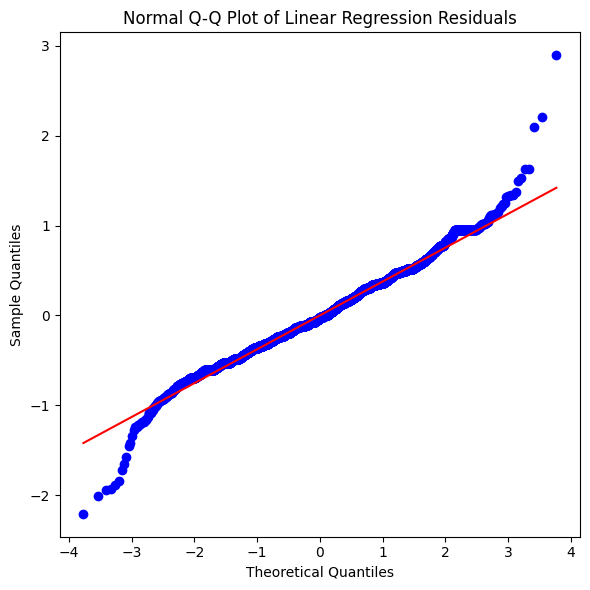

In [52]:
#QQ plot

plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot of Linear Regression Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.tight_layout()
plt.show()

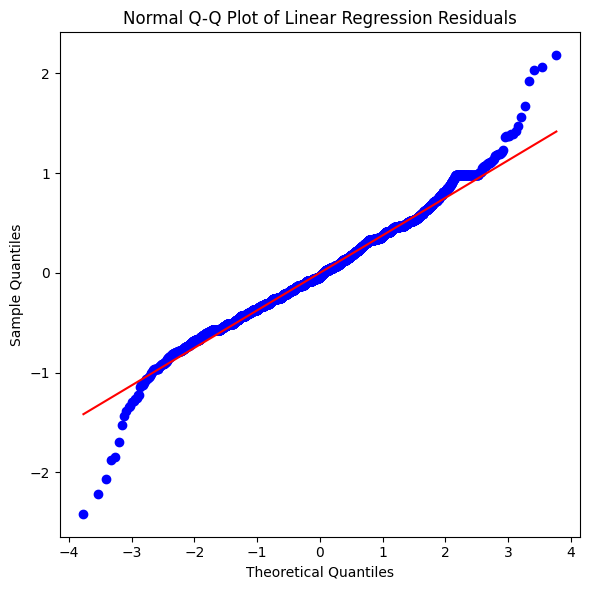

In [53]:
#QQ plot modelo con transformaciones

plt.figure(figsize=(6, 6))
stats.probplot(residuals_t, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot of Linear Regression Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.tight_layout()
plt.show()

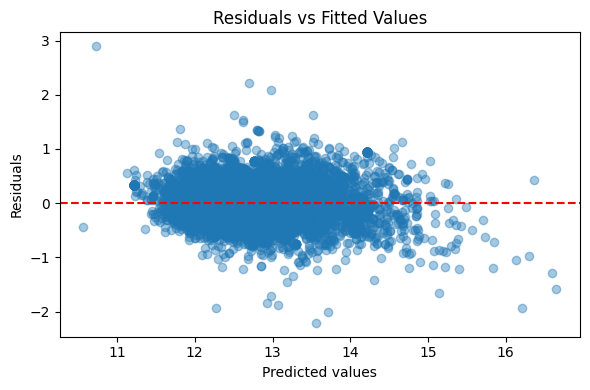

In [54]:
#Sin transformaciones
plt.figure(figsize=(6, 4))
plt.scatter(y_train_pred, residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.tight_layout()
plt.show()


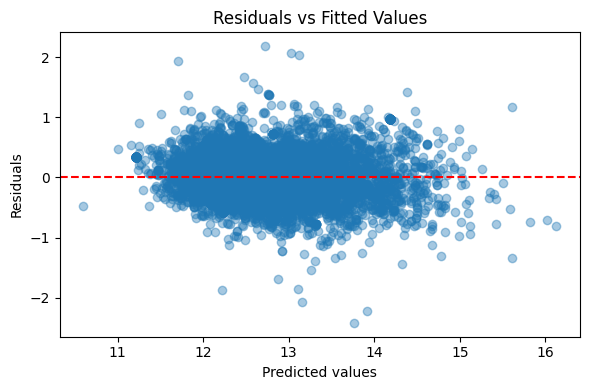

In [55]:
#Con transformaciones
plt.figure(figsize=(6, 4))
plt.scatter(y_train_pred_t, residuals_t, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.tight_layout()
plt.show()

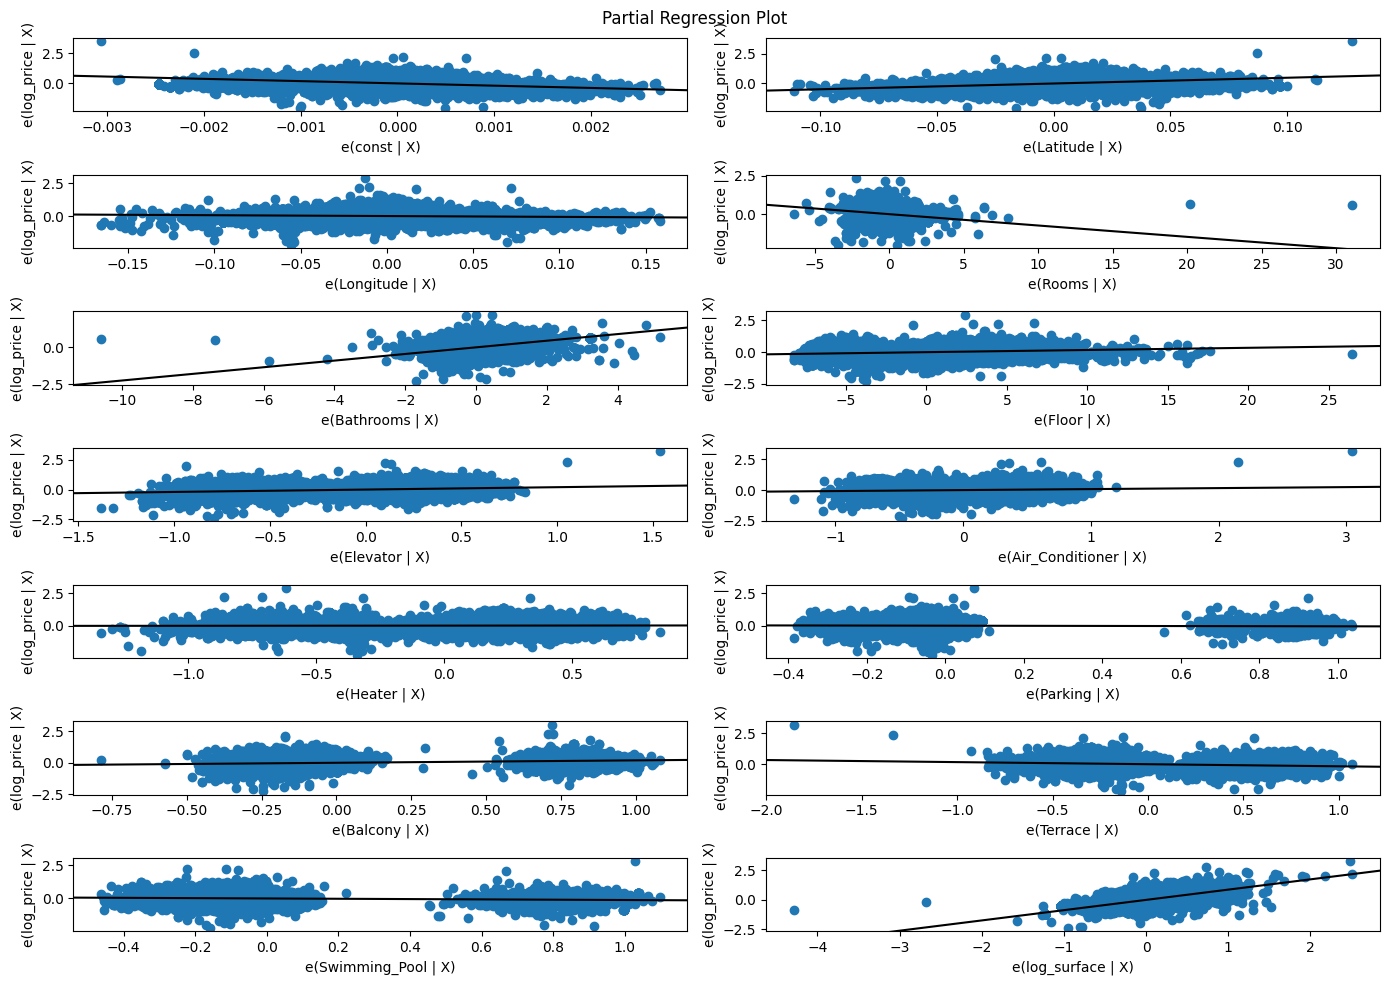

In [56]:
import statsmodels.api as sm

#Sin transformaciones
X_sm = sm.add_constant(X)
model_ols = sm.OLS(y, X_sm).fit()

# Partial regression plots
fig = plt.figure(figsize=(14, 10))
sm.graphics.plot_partregress_grid(model_ols, fig=fig)
plt.tight_layout()
plt.show()

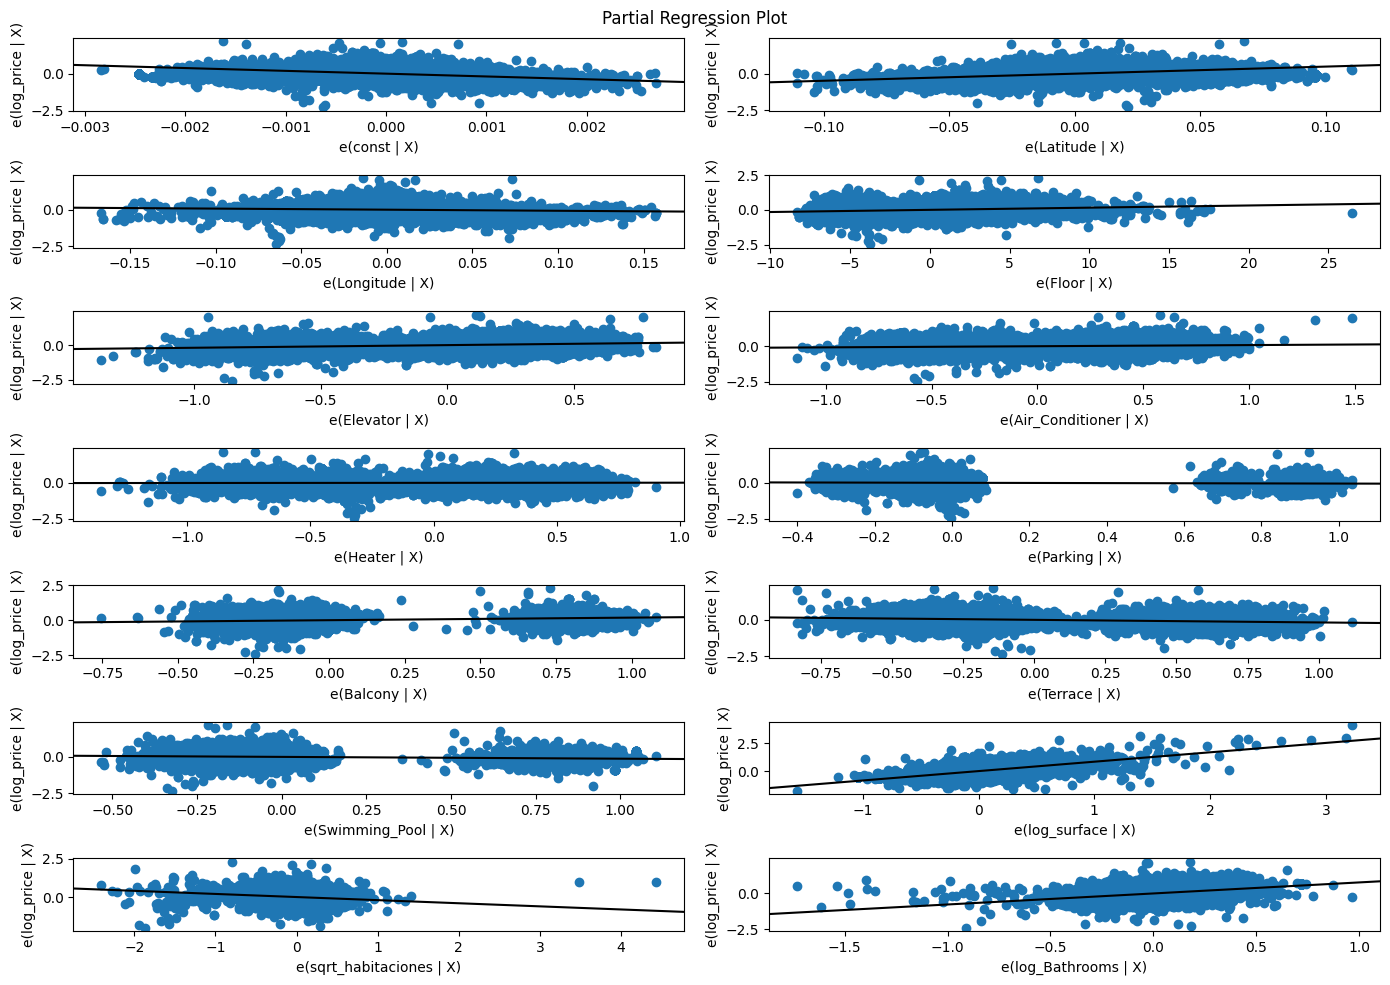

In [57]:
#Con transformaciones

X_sm = sm.add_constant(X_transformed)
model_ols = sm.OLS(y, X_sm).fit()

# Partial regression plots
fig = plt.figure(figsize=(14, 10))
sm.graphics.plot_partregress_grid(model_ols, fig=fig)
plt.tight_layout()
plt.show()

In [58]:
#Validación cruzada
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# R2
cv_r2 = cross_val_score(
    pipe_lm,
    X_train,
    y_train,
    cv=cv,
    scoring="r2")

# RMSE
cv_rmse = cross_val_score(
    pipe_lm,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_root_mean_squared_error")

print(f"R2 CV mean: {cv_r2.mean():.4f}")
print(f"R2 CV std:  {cv_r2.std():.4f}")

print(f"RMSE CV mean: {-cv_rmse.mean():.4f}")
print(f"RMSE CV std:  {cv_rmse.std():.4f}")

R2 CV mean: 0.7767
R2 CV std:  0.0138
RMSE CV mean: 0.3802
RMSE CV std:  0.0101


In [59]:
#Validación cruzada con transformaciones
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# R2
cv_r2 = cross_val_score(
    pipe_lm_t,
    X_train_t,
    y_train,
    cv=cv,
    scoring="r2")

# RMSE
cv_rmse = cross_val_score(
    pipe_lm_t,
    X_train_t,
    y_train,
    cv=cv,
    scoring="neg_root_mean_squared_error")

print(f"R2 CV mean: {cv_r2.mean():.4f}")
print(f"R2 CV std:  {cv_r2.std():.4f}")

print(f"RMSE CV mean: {-cv_rmse.mean():.4f}")
print(f"RMSE CV std:  {cv_rmse.std():.4f}")

R2 CV mean: 0.7785
R2 CV std:  0.0115
RMSE CV mean: 0.3787
RMSE CV std:  0.0088


In [60]:
#Extraer el preprocesador ya entrenado
preprocess_fitted = pipe_lm.named_steps["preprocess"]

#Transformar
X_train_scaled = preprocess_fitted.transform(X_train)

#DataFrame
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns=feature_names,
    index=X_train.index)

#Añadir constante
X_train_scaled = sm.add_constant(X_train_scaled)

#OLS para summary
model_sm = sm.OLS(y_train, X_train_scaled).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     2290.
Date:                Mon, 26 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:19:13   Log-Likelihood:                -3796.6
No. Observations:                8461   AIC:                             7621.
Df Residuals:                    8447   BIC:                             7720.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.6067 

In [61]:
#Modelo con transformaciones

#Extraer el preprocesador ya entrenado
preprocess_fitted_t = pipe_lm_t.named_steps["preprocess"]

#Transformar (NO fit)
X_train_scaled_t = preprocess_fitted_t.transform(X_train_t)

#DataFrame
X_train_scaled_t = pd.DataFrame(
    X_train_scaled_t,
    columns=feature_names_t,
    index=X_train_t.index)

#Añadir constante
X_train_scaled_t = sm.add_constant(X_train_scaled_t)

#OLS para summary
model_sm_t = sm.OLS(y_train, X_train_scaled_t).fit()
print(model_sm_t.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     2307.
Date:                Mon, 26 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:19:13   Log-Likelihood:                -3771.4
No. Observations:                8461   AIC:                             7571.
Df Residuals:                    8447   BIC:                             7669.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     12

Se usa modelo sin escalar para interpretación:

In [62]:
X.head()

,Latitude,Longitude,Rooms,Bathrooms,Floor,Elevator,Air_Conditioner,Heater,Parking,Balcony,Terrace,Swimming_Pool,log_surface
0,40.402584,-3.672911,2,2,0,1,1,1,0,0,0,1,4.624973
1,40.423885,-3.621543,3,1,6,0,0,0,0,0,0,0,3.970292
2,40.423680,-3.621510,3,1,0,0,0,0,0,0,0,0,3.970292
3,40.407387,-3.701162,2,1,0,0,1,1,0,0,0,0,4.219508
4,40.420685,-3.688424,2,2,7,1,1,0,0,1,0,0,5.176150


In [63]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     3846.
Date:                Mon, 26 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:19:13   Log-Likelihood:                -6255.1
No. Observations:               14103   AIC:                         1.254e+04
Df Residuals:                   14089   BIC:                         1.264e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -188.2364      4.112    -

Heater no es significativa, por lo que se va a crear otro modelo sin esta variable.

In [64]:
X.head()

,const,Latitude,Longitude,Rooms,Bathrooms,Floor,Elevator,Air_Conditioner,Heater,Parking,Balcony,Terrace,Swimming_Pool,log_surface
0,1.0,40.402584,-3.672911,2,2,0,1,1,1,0,0,0,1,4.624973
1,1.0,40.423885,-3.621543,3,1,6,0,0,0,0,0,0,0,3.970292
2,1.0,40.423680,-3.621510,3,1,0,0,0,0,0,0,0,0,3.970292
3,1.0,40.407387,-3.701162,2,1,0,0,1,1,0,0,0,0,4.219508
4,1.0,40.420685,-3.688424,2,2,7,1,1,0,0,1,0,0,5.176150


In [65]:
#Preprocesador
preprocess_fitted = pipe_lm.named_steps["preprocess"]

#Transformar X_train
X_train_scaled = preprocess_fitted.transform(X_train)
feature_names = preprocess_fitted.get_feature_names_out()

X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns=feature_names,
    index=X_train.index)

#Quitar Heater
X_train_reduced = X_train_scaled.drop(columns=["bin__Heater"])

#Ajustar modelos
X_full = sm.add_constant(X_train_scaled)
model_full = sm.OLS(y_train, X_full).fit()

X_reduced = sm.add_constant(X_train_reduced)
model_reduced = sm.OLS(y_train, X_reduced).fit()

print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     2479.
Date:                Mon, 26 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:19:13   Log-Likelihood:                -3798.7
No. Observations:                8461   AIC:                             7623.
Df Residuals:                    8448   BIC:                             7715.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.6136 

In [66]:
# 1. Extraer el preprocesador YA AJUSTADO
preprocess_fitted_t = pipe_lm_t.named_steps["preprocess"]

# 2. Transformar X_train_t (NO fit_transform)
X_train_scaled_t = preprocess_fitted_t.transform(X_train_t)

# 3. Nombres reales de las variables
feature_names_t = preprocess_fitted_t.get_feature_names_out()

# 4. DataFrame
X_train_scaled_t = pd.DataFrame(
    X_train_scaled_t,
    columns=feature_names_t,
    index=X_train_t.index)

# 5. MODELO FULL
X_full_t = sm.add_constant(X_train_scaled_t)
model_full_t = sm.OLS(y_train, X_full_t).fit()

# 6. MODELO REDUCIDO (quitar UNA variable)
X_train_reduced_t = X_train_scaled_t.drop(columns=["bin__Heater"])
X_reduced_t = sm.add_constant(X_train_reduced_t)
model_reduced_t = sm.OLS(y_train, X_reduced_t).fit()

# 7. Summary del modelo reducido
print(model_reduced_t.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     2499.
Date:                Mon, 26 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:19:13   Log-Likelihood:                -3772.9
No. Observations:                8461   AIC:                             7572.
Df Residuals:                    8448   BIC:                             7663.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     12

In [67]:
from itertools import combinations
from scipy.stats import chi2_contingency, fisher_exact

results = []

for v1, v2 in combinations(binary_vars, 2):
    table = pd.crosstab(df[v1], df[v2])
    n = table.values.sum()

    if (table.values < 5).any():
        # Fisher: no devuelve chi2 → lo calculamos igualmente con chi2_contingency
        chicuad, _, _, _ = chi2_contingency(table)
        _, p = fisher_exact(table)
        test = "Fisher"
    else:
        chicuad, p, _, _ = chi2_contingency(table)
        test = "Chi2"

    # V de Cramér (binarias → divisor = n)
    cramers_v = np.sqrt(chicuad / n)

    results.append({
        "var1": v1,
        "var2": v2,
        "test": test,
        "p_value": round(p, 3),
        "cramers_v": round(cramers_v, 3)})

pairs_df = pd.DataFrame(results)

pairs_df_sorted = (
    pairs_df
    .sort_values(
        by=["p_value", "cramers_v"],
        ascending=[True, False]))

pairs_df_sorted.head(20)
#V < 0.1 → despreciable
#0.1–0.3 → moderada
#0.3 → fuerte

#p-valor alto + V bajo → independencia clara
#p-valor bajo + V alto → colinealidad real
#p-valor bajo + V bajo → dependencia estadística pero irrelevante en práctica
# H0: Las dos variables categóricas son independientes.


,var1,var2,test,p_value,cramers_v
6,Air_Conditioner,Heater,Chi2,0.000,0.282
0,Elevator,Air_Conditioner,Chi2,0.000,0.239
17,Parking,Swimming_Pool,Chi2,0.000,0.228
13,Heater,Terrace,Chi2,0.000,0.222
1,Elevator,Heater,Chi2,0.000,0.152
2,Elevator,Parking,Chi2,0.000,0.146
14,Heater,Swimming_Pool,Chi2,0.000,0.141
7,Air_Conditioner,Parking,Chi2,0.000,0.140
20,Terrace,Swimming_Pool,Chi2,0.000,0.131
11,Heater,Parking,Chi2,0.000,0.125


Contraste de razon de verosimilitud

In [68]:
from scipy.stats import chi2

LR = 2 * (model_full.llf - model_reduced.llf)
p_value = chi2.sf(LR, df=1)

print("LR:", LR)
print("p-value:", p_value)

LR: 4.206320840821718
p-value: 0.04027359848341855


In [69]:
# Variabels transformadas
LR_t = 2 * (model_full_t.llf - model_reduced_t.llf)
p_value_t = chi2.sf(LR_t, df=1)

print(f"LR statistic: {LR_t:.4f}")
print(f"p-value: {p_value_t:.4f}")

LR statistic: 2.9428
p-value: 0.0863


In [70]:
X_num = X_train[num_vars].copy()

X_num_scaled = StandardScaler().fit_transform(X_num)

vif_df = pd.DataFrame()
vif_df["Variable"] = num_vars
vif_df["VIF"] = [
    variance_inflation_factor(X_num_scaled, i)
    for i in range(X_num_scaled.shape[1])]

vif_df.sort_values("VIF", ascending=False)

,Variable,VIF
0,log_surface,2.580738
2,Bathrooms,2.350862
1,Rooms,2.073306
4,Latitude,1.100666
3,Floor,1.032748
5,Longitude,1.025279


In [71]:
X_num = X_train_t[num_vars_t].copy()

X_num_scaled = StandardScaler().fit_transform(X_num)

vif_df = pd.DataFrame()
vif_df["Variable"] = num_vars_t
vif_df["VIF"] = [
    variance_inflation_factor(X_num_scaled, i)
    for i in range(X_num_scaled.shape[1])]

vif_df.sort_values("VIF", ascending=False)

,Variable,VIF
0,log_surface,2.808928
2,log_Bathrooms,2.406101
1,sqrt_habitaciones,1.909366
4,Latitude,1.113308
5,Longitude,1.031989
3,Floor,1.025568


# Ridge

In [72]:
alphas = np.logspace(-3, 5, 100)

pipe_ridge_cv = Pipeline(steps=[
    ("preprocess", preprocess_scaled_tranformed),
    ("model", RidgeCV(alphas=alphas, cv=10))])

pipe_ridge_cv.fit(X_train_t, y_train)

# Alpha óptimo
pipe_ridge_cv.named_steps["model"].alpha_

np.float64(6.280291441834259)

In [73]:
alphas

array([1.00000000e-03, 1.20450354e-03, 1.45082878e-03, 1.74752840e-03,
       2.10490414e-03, 2.53536449e-03, 3.05385551e-03, 3.67837977e-03,
       4.43062146e-03, 5.33669923e-03, 6.42807312e-03, 7.74263683e-03,
       9.32603347e-03, 1.12332403e-02, 1.35304777e-02, 1.62975083e-02,
       1.96304065e-02, 2.36448941e-02, 2.84803587e-02, 3.43046929e-02,
       4.13201240e-02, 4.97702356e-02, 5.99484250e-02, 7.22080902e-02,
       8.69749003e-02, 1.04761575e-01, 1.26185688e-01, 1.51991108e-01,
       1.83073828e-01, 2.20513074e-01, 2.65608778e-01, 3.19926714e-01,
       3.85352859e-01, 4.64158883e-01, 5.59081018e-01, 6.73415066e-01,
       8.11130831e-01, 9.77009957e-01, 1.17681195e+00, 1.41747416e+00,
       1.70735265e+00, 2.05651231e+00, 2.47707636e+00, 2.98364724e+00,
       3.59381366e+00, 4.32876128e+00, 5.21400829e+00, 6.28029144e+00,
       7.56463328e+00, 9.11162756e+00, 1.09749877e+01, 1.32194115e+01,
       1.59228279e+01, 1.91791026e+01, 2.31012970e+01, 2.78255940e+01,
      

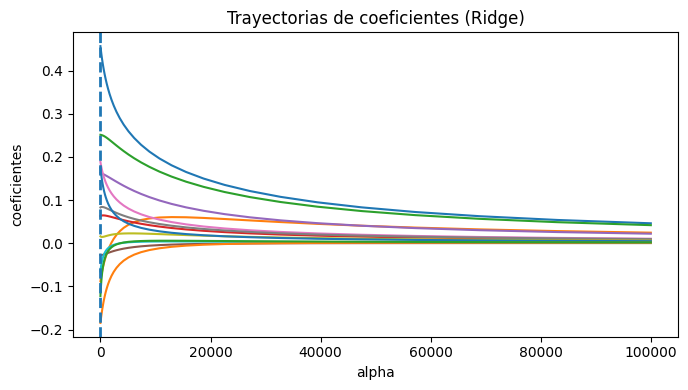

In [74]:
from sklearn.linear_model import Ridge

coefs = []

for a in alphas:
    pipe = Pipeline(steps=[
        ("preprocess", preprocess_scaled_tranformed),
        ("model", Ridge(alpha=a))])
    pipe.fit(X_train_t, y_train)
    coefs.append(pipe.named_steps["model"].coef_)

coefs = np.array(coefs)

plt.figure(figsize=(7, 4))

for i, name in enumerate(feature_names):
    plt.plot(alphas, coefs[:, i], label=name)

#plt.xscale("log")
plt.axvline(
    pipe_ridge_cv.named_steps["model"].alpha_,
    linestyle="--",
    linewidth=2)

plt.xlabel("alpha")
plt.ylabel("coeficientes")
plt.title("Trayectorias de coeficientes (Ridge)")
plt.tight_layout()
plt.show()




In [75]:
y_train_pred = pipe_ridge_cv.predict(X_train_t)
y_test_pred  = pipe_ridge_cv.predict(X_test_t)

print("RIDGE (CV)")
print(f"Alpha óptimo: {pipe_ridge_cv.named_steps['model'].alpha_:.4f}")
print(f"Train R2: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test  R2: {r2_score(y_test, y_test_pred):.4f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
print(f"Test  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")

RIDGE (CV)
Alpha óptimo: 6.2803
Train R2: 0.7803
Test  R2: 0.7828
Train RMSE: 0.3779
Test  RMSE: 0.3733


#Lasso

In [76]:
# Grid de alphas (el mismo rango que Ridge)
alphas = np.logspace(-3, 3, 50)

# Pipeline Lasso
pipe_lasso_cv = Pipeline(steps=[
    ("preprocess", preprocess_scaled_tranformed),
    ("model", LassoCV(alphas=alphas, cv=10, max_iter=10000))])

# Ajustar
pipe_lasso_cv.fit(X_train_t, y_train)

# Alpha óptimo
alpha_lasso = pipe_lasso_cv.named_steps["model"].alpha_
alpha_lasso

np.float64(0.001)

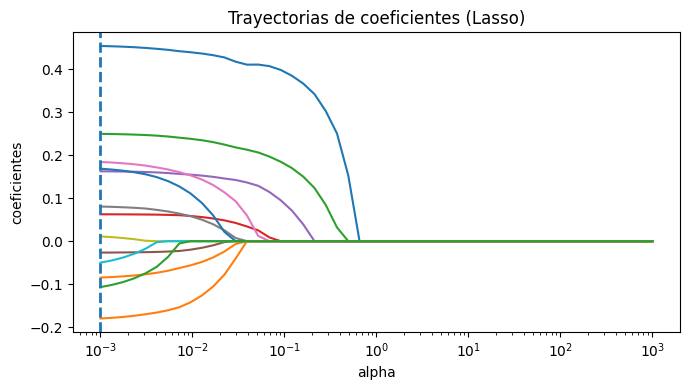

In [77]:
from sklearn.linear_model import Lasso

coefs_lasso = []

for a in alphas:
    pipe = Pipeline(steps=[
        ("preprocess", preprocess_scaled_tranformed),
        ("model", Lasso(alpha=a, max_iter=10000))])
    pipe.fit(X_train_t, y_train)
    coefs_lasso.append(pipe.named_steps["model"].coef_)

coefs_lasso = np.array(coefs_lasso)

plt.figure(figsize=(7, 4))

for i, name in enumerate(feature_names):
    plt.plot(alphas, coefs_lasso[:, i], label=name)

plt.xscale("log")

# Alpha óptimo de LassoCV
plt.axvline(
    alpha_lasso,
    linestyle="--",
    linewidth=2)

plt.xlabel("alpha")
plt.ylabel("coeficientes")
plt.title("Trayectorias de coeficientes (Lasso)")
plt.tight_layout()
plt.show()

In [78]:
y_train_pred = pipe_lasso_cv.predict(X_train_t)
y_test_pred  = pipe_lasso_cv.predict(X_test_t)

print("LASSO (CV)")
print(f"Alpha óptimo: {alpha_lasso:.4f}")
print(f"Train R2: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test  R2: {r2_score(y_test, y_test_pred):.4f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
print(f"Test  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")

LASSO (CV)
Alpha óptimo: 0.0010
Train R2: 0.7802
Test  R2: 0.7828
Train RMSE: 0.3780
Test  RMSE: 0.3733


In [79]:
# Nombres de variables tras el preprocesamiento
feature_names = preprocess_scaled.get_feature_names_out()

# Coeficientes Lasso
lasso_coefs = pipe_lasso_cv.named_steps["model"].coef_

lasso_df = pd.DataFrame({
    "Variable": feature_names,
    "Coeficiente_Lasso": lasso_coefs})

# Variables NO nulas
lasso_selected = (
    lasso_df[lasso_df["Coeficiente_Lasso"] != 0]
    .sort_values(by="Coeficiente_Lasso", key=abs, ascending=False))

lasso_selected

,Variable,Coeficiente_Lasso
0,num__log_surface,0.454193
2,num__Bathrooms,0.249745
6,bin__Elevator,0.184342
11,bin__Terrace,-0.179871
10,bin__Balcony,0.168655
4,num__Latitude,0.162585
12,bin__Swimming_Pool,-0.106833
1,num__Rooms,-0.084611
7,bin__Air_Conditioner,0.080619
3,num__Floor,0.062557


In [80]:
alphas_grid = np.logspace(-3, 1, 20)  # prueba hasta 10
feature_names = preprocess_scaled.get_feature_names_out()

rows = []
for a in alphas_grid:
    pipe_tmp = Pipeline(steps=[
        ("preprocess", preprocess_scaled),
        ("model", Lasso(alpha=a, max_iter=20000))])
    pipe_tmp.fit(X_train, y_train)
    coefs = pipe_tmp.named_steps["model"].coef_
    n_nonzero = np.sum(coefs != 0)
    heater_coef = coefs[list(feature_names).index("bin__Heater")] if "bin__Heater" in feature_names else np.nan
    rows.append([a, n_nonzero, heater_coef])

path_df = pd.DataFrame(rows, columns=["alpha", "n_nonzero", "heater_coef"])
path_df

,alpha,n_nonzero,heater_coef
0,0.001000,13,0.014136
1,0.001624,13,0.011090
2,0.002637,13,0.006144
3,0.004281,11,0.000000
4,0.006952,11,0.000000
5,0.011288,10,0.000000
6,0.018330,10,0.000000
7,0.029764,8,0.000000
8,0.048329,5,0.000000
9,0.078476,4,0.000000


In [81]:
mse_path = pipe_lasso_cv.named_steps["model"].mse_path_.mean(axis=1)
mse_std  = pipe_lasso_cv.named_steps["model"].mse_path_.std(axis=1) / np.sqrt(pipe_lasso_cv.named_steps["model"].mse_path_.shape[1])
alphas   = pipe_lasso_cv.named_steps["model"].alphas_

min_idx = np.argmin(mse_path)
mse_min = mse_path[min_idx]
threshold = mse_min + mse_std[min_idx]  # 1-SE

# alpha más grande cuyo MSE esté por debajo del umbral
idx_1se = np.where(mse_path <= threshold)[0][-1]
alpha_1se = alphas[idx_1se]
alpha_lasso = pipe_lasso_cv.named_steps["model"].alpha_

alpha_lasso, alpha_1se

(np.float64(0.001), np.float64(0.001))

In [82]:
pipe_lasso_1se = Pipeline(steps=[
    ("preprocess", preprocess_scaled),
    ("model", Lasso(alpha=alpha_1se, max_iter=20000))])
pipe_lasso_1se.fit(X_train, y_train)

coefs_1se = pipe_lasso_1se.named_steps["model"].coef_

lasso_1se_df = pd.DataFrame({
    "Variable": preprocess_scaled.get_feature_names_out(),
    "Coef": coefs_1se})

lasso_1se_selected = lasso_1se_df[lasso_1se_df["Coef"] != 0].sort_values(by="Coef", key=abs, ascending=False)
lasso_1se_selected

,Variable,Coef
0,num__log_surface,0.465612
2,num__Bathrooms,0.245075
6,bin__Elevator,0.194385
10,bin__Balcony,0.175855
11,bin__Terrace,-0.170207
4,num__Latitude,0.161759
12,bin__Swimming_Pool,-0.095666
1,num__Rooms,-0.089836
7,bin__Air_Conditioner,0.081134
3,num__Floor,0.068061


## Decision Tree

In [83]:
pipe_tree = Pipeline(steps=[
    ("preprocess", preprocess_scaled),
    ("model", DecisionTreeRegressor(random_state=42))])

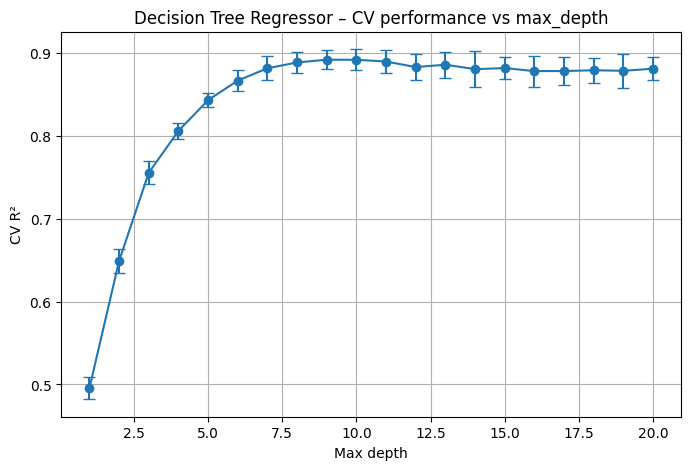

In [84]:
depths = range(1, 21)
mean_r2 = []
std_r2 = []

cv = KFold(n_splits=10, shuffle=True, random_state=42)

for d in depths:
    pipe_tree.set_params(model__max_depth=d)

    scores = cross_val_score(
        pipe_tree,
        X_train,
        y_train,
        cv=cv,
        scoring="r2")

    mean_r2.append(scores.mean())
    std_r2.append(scores.std())

# Gráfico
plt.figure(figsize=(8,5))
plt.errorbar(depths, mean_r2, yerr=std_r2, marker="o", capsize=4)
plt.xlabel("Max depth")
plt.ylabel("CV R²")
plt.title("Decision Tree Regressor – CV performance vs max_depth")
plt.grid(True)
plt.show()

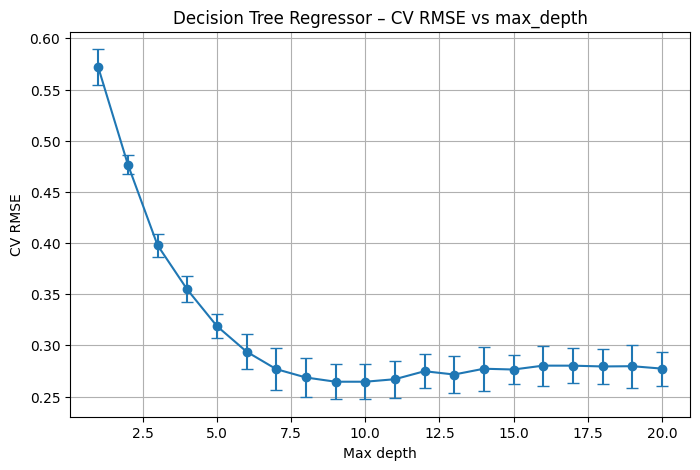

In [85]:
mean_rmse = []
std_rmse = []

for d in depths:
    pipe_tree.set_params(model__max_depth=d)

    scores = cross_val_score(
        pipe_tree,
        X_train,
        y_train,
        cv=cv,
        scoring="neg_root_mean_squared_error")

    rmse = -scores
    mean_rmse.append(rmse.mean())
    std_rmse.append(rmse.std())

plt.figure(figsize=(8,5))
plt.errorbar(depths, mean_rmse, yerr=std_rmse, marker="o", capsize=4)
plt.xlabel("Max depth")
plt.ylabel("CV RMSE")
plt.title("Decision Tree Regressor – CV RMSE vs max_depth")
plt.grid(True)
plt.show()

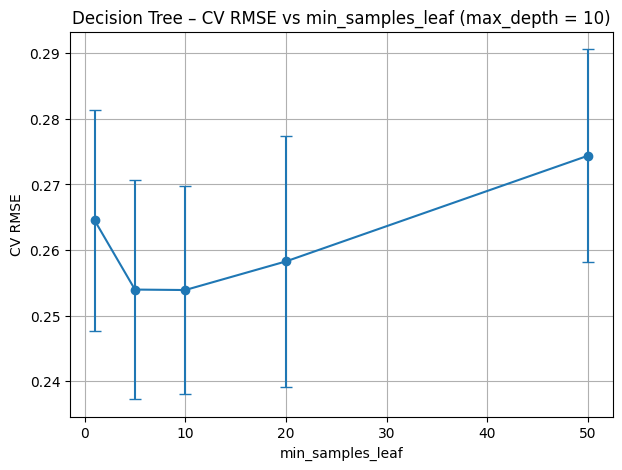

In [86]:
leaf_sizes = [1, 5, 10, 20, 50]
mean_rmse = []
std_rmse = []
pipe_tree.set_params(model__max_depth=10)

for leaf in leaf_sizes:
    pipe_tree.set_params(model__min_samples_leaf=leaf)

    scores = cross_val_score(
        pipe_tree,
        X_train,
        y_train,
        cv=cv,
        scoring="neg_root_mean_squared_error")

    rmse = -scores
    mean_rmse.append(rmse.mean())
    std_rmse.append(rmse.std())

plt.figure(figsize=(7,5))
plt.errorbar(leaf_sizes, mean_rmse, yerr=std_rmse, marker="o", capsize=4)
plt.xlabel("min_samples_leaf")
plt.ylabel("CV RMSE")
plt.title("Decision Tree – CV RMSE vs min_samples_leaf (max_depth = 10)")
plt.grid(True)
plt.show()

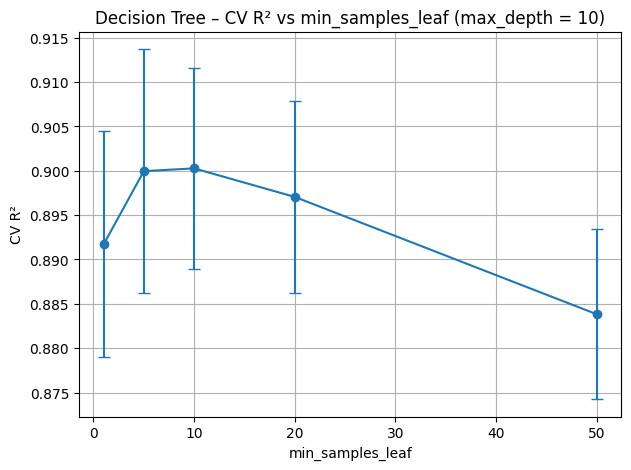

In [87]:
leaf_sizes = [1, 5, 10, 20, 50]
mean_r2 = []
std_r2 = []
pipe_tree.set_params(model__max_depth=10)

for leaf in leaf_sizes:
    pipe_tree.set_params(model__min_samples_leaf=leaf)

    scores = cross_val_score(
        pipe_tree,
        X_train,
        y_train,
        cv=cv,
        scoring="r2")

    mean_r2.append(scores.mean())
    std_r2.append(scores.std())

plt.figure(figsize=(7,5))
plt.errorbar(leaf_sizes, mean_r2, yerr=std_r2, marker="o", capsize=4)
plt.xlabel("min_samples_leaf")
plt.ylabel("CV R²")
plt.title("Decision Tree – CV R² vs min_samples_leaf (max_depth = 10)")
plt.grid(True)
plt.show()

## Modelo optimizado

In [88]:
#GridSearch para parámetros óptimos
pipe_tree = Pipeline(steps=[
    ("preprocess", preprocess_scaled),
    ("model", DecisionTreeRegressor(random_state=42))])

param_grid = {
    "model__max_depth": [4, 6, 8, 10, 12,20],
    "model__min_samples_leaf": [1, 5, 10, 25, 50, 100],}

grid_tree = GridSearchCV(
    pipe_tree,
    param_grid=param_grid,
    cv=10,
    scoring="r2",
    n_jobs=-1)

grid_tree.fit(X_train, y_train)
grid_tree.best_params_

{'model__max_depth': 12, 'model__min_samples_leaf': 5}

In [89]:
#Parámetros optimizados
pipe_tree = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", DecisionTreeRegressor(
        max_depth=12,
        min_samples_leaf=5,
        random_state=42))])

pipe_tree.fit(X_train, y_train)

y_train_pred_tree = pipe_tree.predict(X_train)
y_test_pred_tree  = pipe_tree.predict(X_test)

print("TRAIN")
print(f" R2:   {r2_score(y_train, y_train_pred_tree):.4f}")
print(f" RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_tree)):.4f}")

print("\nTEST")
print(f" R2:   {r2_score(y_test, y_test_pred_tree):.4f}")
print(f" RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_tree)):.4f}")

TRAIN
 R2:   0.9603
 RMSE: 0.1607

TEST
 R2:   0.9090
 RMSE: 0.2416


In [90]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# R2
cv_r2_tree = cross_val_score(
    pipe_tree,
    X_train,
    y_train,
    cv=cv,
    scoring="r2")

# RMSE
cv_rmse_tree = cross_val_score(
    pipe_tree,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_root_mean_squared_error")

print(f"Tree R2 CV mean: {cv_r2_tree.mean():.4f}")
print(f"Tree R2 CV std:  {cv_r2_tree.std():.4f}")

print(f"Tree RMSE CV mean: {-cv_rmse_tree.mean():.4f}")
print(f"Tree RMSE CV std:  {cv_rmse_tree.std():.4f}")

Tree R2 CV mean: 0.9005
Tree R2 CV std:  0.0108
Tree RMSE CV mean: 0.2539
Tree RMSE CV std:  0.0149


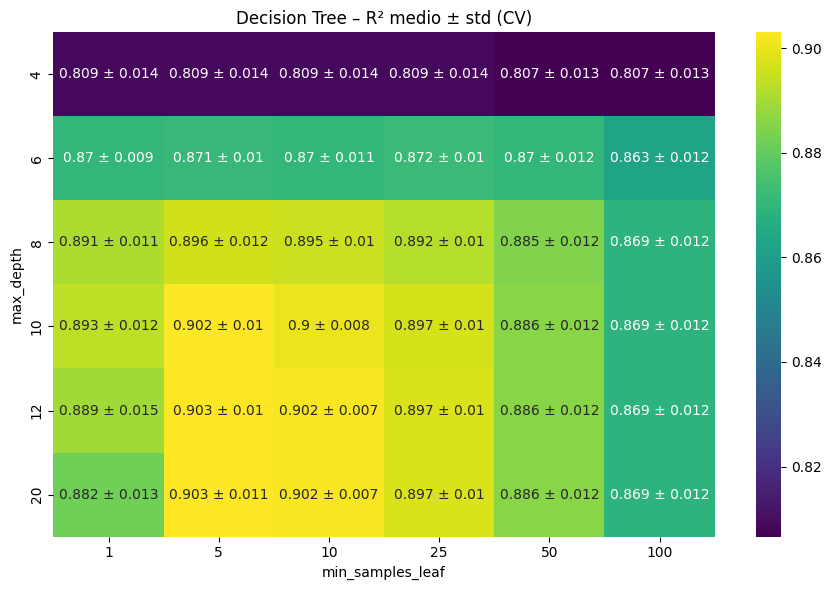

In [91]:
results = pd.DataFrame(grid_tree.cv_results_)

results = results[[
    "param_model__max_depth",
    "param_model__min_samples_leaf",
    "mean_test_score",
    "std_test_score"]]

results.head()

# Matrices de media y std
r2_matrix = results.pivot(
    index="param_model__max_depth",
    columns="param_model__min_samples_leaf",
    values="mean_test_score")

std_matrix = results.pivot(
    index="param_model__max_depth",
    columns="param_model__min_samples_leaf",
    values="std_test_score")

# Matriz de anotaciones: "media ± std"
annot_matrix = (
    r2_matrix.round(3).astype(str)
    + " ± "
    + std_matrix.round(3).astype(str))

plt.figure(figsize=(9, 6))

sns.heatmap(
    r2_matrix,
    annot=annot_matrix,
    fmt="",
    cmap="viridis")

plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.title("Decision Tree – R² medio ± std (CV)")
plt.tight_layout()
plt.show()


## Modelo Heurístico

In [92]:
#parámetros elegidos por mi (método heurísitica)
pipe_tree_heuristic = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", DecisionTreeRegressor(
        max_depth=8,
        min_samples_leaf=10,
        random_state=42))])

pipe_tree_heuristic.fit(X_train, y_train)

y_train_pred_tree = pipe_tree_heuristic.predict(X_train)
y_test_pred_tree  = pipe_tree_heuristic.predict(X_test)

print("TRAIN")
print(f" R2:   {r2_score(y_train, y_train_pred_tree):.4f}")
print(f" RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_tree)):.4f}")

print("\nTEST")
print(f" R2:   {r2_score(y_test, y_test_pred_tree):.4f}")
print(f" RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_tree)):.4f}")

TRAIN
 R2:   0.9209
 RMSE: 0.2268

TEST
 R2:   0.8962
 RMSE: 0.2581


In [93]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# R2
cv_r2_tree = cross_val_score(
    pipe_tree_heuristic,
    X_train,
    y_train,
    cv=cv,
    scoring="r2")

# RMSE
cv_rmse_tree = cross_val_score(
    pipe_tree_heuristic,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_root_mean_squared_error")

print(f"Tree R2 CV mean: {cv_r2_tree.mean():.4f}")
print(f"Tree R2 CV std:  {cv_r2_tree.std():.4f}")

print(f"Tree RMSE CV mean: {-cv_rmse_tree.mean():.4f}")
print(f"Tree RMSE CV std:  {cv_rmse_tree.std():.4f}")

Tree R2 CV mean: 0.8903
Tree R2 CV std:  0.0132
Tree RMSE CV mean: 0.2665
Tree RMSE CV std:  0.0175


Importancia de variables

In [94]:
# Este código que he comentado no me funciona. Con lo que he corregido, ya sí:
#feature_names = preprocess_tree.get_feature_names_out()
feature_names = (
    pipe_tree
    .named_steps["preprocess"]
    .get_feature_names_out())

feature_names

importances_tree = pipe_tree.named_steps["model"].feature_importances_

importance_tree_df = (
    pd.DataFrame({
        "Variable": feature_names,
        "Importance": importances_tree})
    .sort_values(by="Importance", ascending=False))

importance_tree_df.head(15)

,Variable,Importance
0,num__log_surface,0.642192
4,num__Latitude,0.158346
2,num__Bathrooms,0.111381
5,num__Longitude,0.058723
6,bin__Elevator,0.009633
3,num__Floor,0.006324
1,num__Rooms,0.004572
7,bin__Air_Conditioner,0.003730
12,bin__Swimming_Pool,0.001881
8,bin__Heater,0.001573


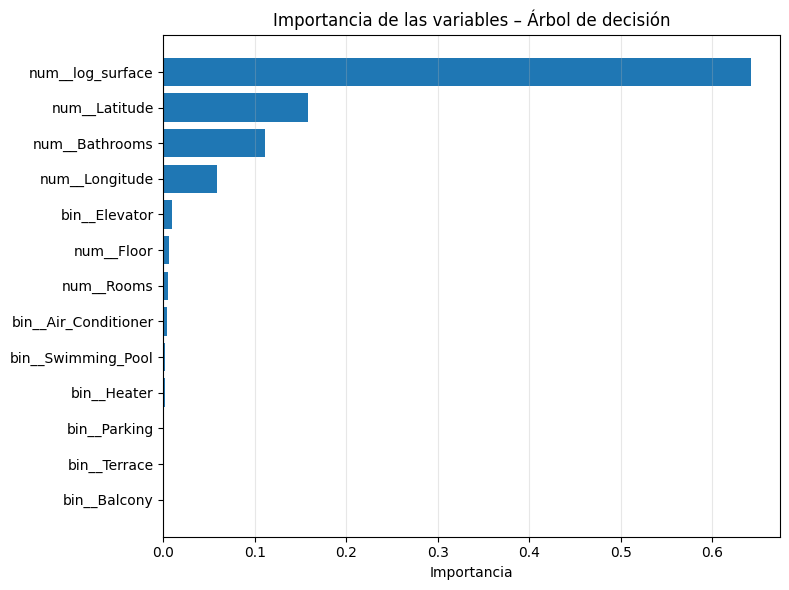

In [95]:
# Extraer nombres de variables tras el preprocesado
#feature_names = preprocess_tree.get_feature_names_out()
feature_names = (
    pipe_tree
    .named_steps["preprocess"]
    .get_feature_names_out())

feature_names

# Extraer importancias del árbol
importances = pipe_tree.named_steps["model"].feature_importances_

# DataFrame
importance_df = (
    pd.DataFrame({
        "Variable": feature_names,
        "Importance": importances})
    .sort_values("Importance", ascending=False))

# Gráfico
plt.figure(figsize=(8, 6))
plt.barh(
    importance_df["Variable"],
    importance_df["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.title("Importancia de las variables – Árbol de decisión")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

In [96]:
pipe_tree.named_steps["model"].get_depth()

12

In [97]:
pipe_tree.named_steps["model"].get_n_leaves()

np.int64(720)

## Modelo reducido (arbol de decision)

In [98]:
# Seleccionar top k variables por importancia
top_k = 4
top_vars = importance_df.head(top_k)["Variable"].tolist()

top_vars

['num__log_surface', 'num__Latitude', 'num__Bathrooms', 'num__Longitude']

In [99]:
# Quitar prefijos num__ y bin__
top_vars_clean = [v.split("__")[1] for v in top_vars]
top_vars_clean

['log_surface', 'Latitude', 'Bathrooms', 'Longitude']

In [100]:
# Detectar cuáles son numéricas y binarias
top_num_vars = [v for v in top_vars_clean if v in num_vars]
top_bin_vars = [v for v in top_vars_clean if v in bin_vars]

preprocess_tree_reduced = ColumnTransformer(
    transformers=[
        ("num", "passthrough", top_num_vars),
        ("bin", "passthrough", top_bin_vars)])

In [101]:
pipe_tree_reduced = Pipeline(steps=[
    ("preprocess", preprocess_tree_reduced),
    ("model", DecisionTreeRegressor(
        max_depth=12,
        min_samples_leaf=5,
        random_state=42))])

In [102]:
pipe_tree_reduced.fit(X_train, y_train)

y_train_pred_red = pipe_tree_reduced.predict(X_train)
y_test_pred_red  = pipe_tree_reduced.predict(X_test)

print("ÁRBOL REDUCIDO")
print(f"Train R2:  {r2_score(y_train, y_train_pred_red):.4f}")
print(f"Test  R2:  {r2_score(y_test, y_test_pred_red):.4f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_red)):.4f}")
print(f"Test  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_red)):.4f}")

ÁRBOL REDUCIDO
Train R2:  0.9551
Test  R2:  0.9054
Train RMSE: 0.1709
Test  RMSE: 0.2463


In [103]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_tree_red = cross_val_score(
    pipe_tree_reduced,
    X_train,
    y_train,
    cv=cv,
    scoring="r2",
    n_jobs=-1)

cv_rmse_tree = cross_val_score(
    pipe_tree_reduced,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_root_mean_squared_error")

print("ÁRBOL REDUCIDO (CV)")
print(f"R2 medio: {cv_scores_tree_red.mean():.4f}")
print(f"Desv. estándar R2: {cv_scores_tree_red.std():.4f}")
print(f"RMSE medio: {-cv_rmse_tree.mean():.4f}")
print(f"Desv. estándar RMSE:  {cv_rmse_tree.std():.4f}")

ÁRBOL REDUCIDO (CV)
R2 medio: 0.9011
Desv. estándar R2: 0.0124
RMSE medio: 0.2530
Desv. estándar RMSE:  0.0166


## Random Forest

In [104]:
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1))])

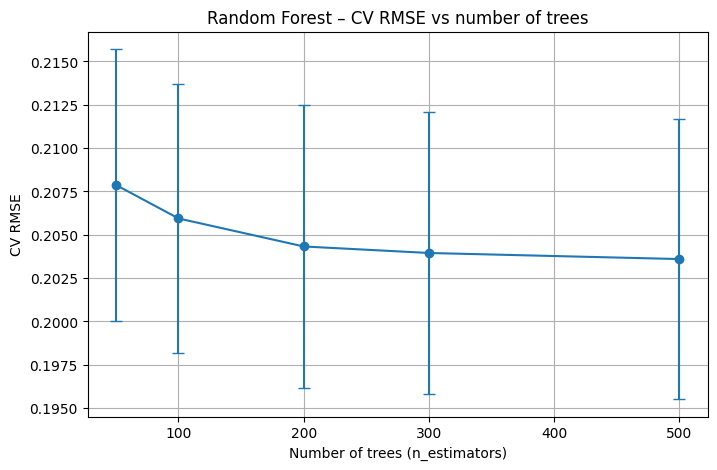

In [105]:
# Error según n_estimators
n_trees = [50, 100, 200, 300, 500]
mean_rmse = []
std_rmse = []

pipe_rf.set_params(
    model__max_depth=None,
    model__min_samples_leaf=1,
    model__max_features="sqrt")

for n in n_trees:
    pipe_rf.set_params(model__n_estimators=n)

    scores = cross_val_score(
        pipe_rf,
        X_train,
        y_train,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1)

    rmse = -scores
    mean_rmse.append(rmse.mean())
    std_rmse.append(rmse.std())

plt.figure(figsize=(8,5))
plt.errorbar(n_trees, mean_rmse, yerr=std_rmse, marker="o", capsize=4)
plt.xlabel("Number of trees (n_estimators)")
plt.ylabel("CV RMSE")
plt.title("Random Forest – CV RMSE vs number of trees")
plt.grid(True)
plt.show()

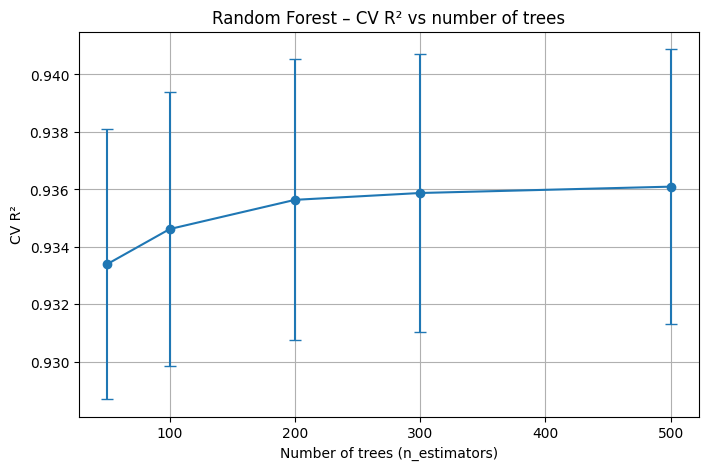

In [106]:
#r2 según n_estimators

n_trees = [50, 100, 200, 300, 500]
mean_r2 = []
std_r2 = []

pipe_rf.set_params(
    model__max_depth=None,
    model__min_samples_leaf=1,
    model__max_features="sqrt")

for n in n_trees:
    pipe_rf.set_params(model__n_estimators=n)

    scores = cross_val_score(
        pipe_rf,
        X_train,
        y_train,
        cv=cv,
        scoring="r2",
        n_jobs=-1)

    mean_r2.append(scores.mean())
    std_r2.append(scores.std())

plt.figure(figsize=(8,5))
plt.errorbar(n_trees, mean_r2, yerr=std_r2, marker="o", capsize=4)
plt.xlabel("Number of trees (n_estimators)")
plt.ylabel("CV R²")
plt.title("Random Forest – CV R² vs number of trees")
plt.grid(True)
plt.show()


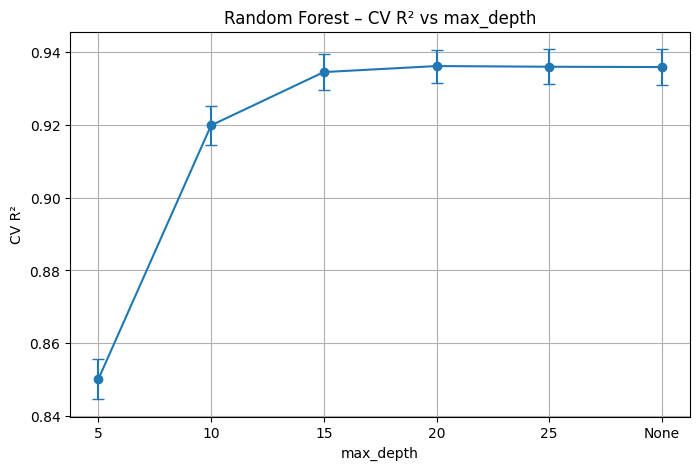

In [107]:
#max_depth r2
depths = [5, 10, 15, 20, 25, None]
x_pos = np.arange(len(depths))

mean_r2 = []
std_r2 = []

pipe_rf.set_params(
    model__n_estimators=300,
    model__max_features="sqrt",
    model__min_samples_leaf=1)

for d in depths:
    pipe_rf.set_params(model__max_depth=d)

    scores = cross_val_score(
        pipe_rf,
        X_train,
        y_train,
        cv=cv,
        scoring="r2",
        n_jobs=-1)

    mean_r2.append(scores.mean())
    std_r2.append(scores.std())

plt.figure(figsize=(8,5))
plt.errorbar(x_pos, mean_r2, yerr=std_r2, marker="o", capsize=4)
plt.xticks(x_pos, ["5", "10", "15", "20", "25", "None"])
plt.xlabel("max_depth")
plt.ylabel("CV R²")
plt.title("Random Forest – CV R² vs max_depth")
plt.grid(True)
plt.show()

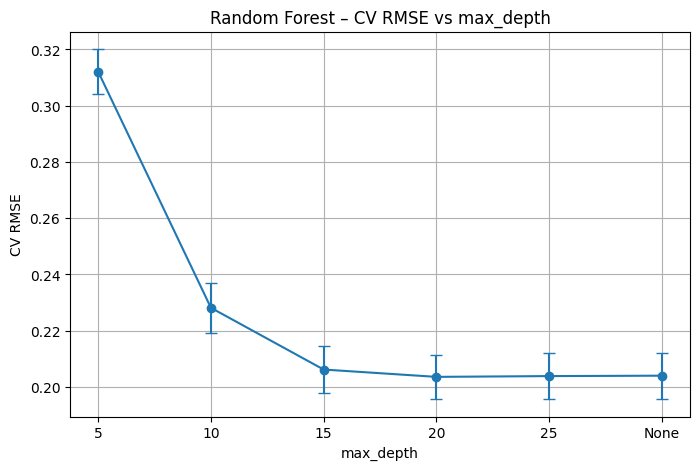

In [108]:
#max_depth error

depths = [5, 10, 15, 20, 25, None]
x_pos = np.arange(len(depths))

mean_rmse = []
std_rmse = []

pipe_rf.set_params(
    model__n_estimators=300,
    model__max_features="sqrt",
    model__min_samples_leaf=1)

for d in depths:
    pipe_rf.set_params(model__max_depth=d)

    scores = cross_val_score(
        pipe_rf,
        X_train,
        y_train,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1)

    rmse = -scores
    mean_rmse.append(rmse.mean())
    std_rmse.append(rmse.std())

plt.figure(figsize=(8,5))
plt.errorbar(x_pos, mean_rmse, yerr=std_rmse, marker="o", capsize=4)
plt.xticks(x_pos, ["5", "10", "15", "20", "25", "None"])
plt.xlabel("max_depth")
plt.ylabel("CV RMSE")
plt.title("Random Forest – CV RMSE vs max_depth")
plt.grid(True)
plt.show()


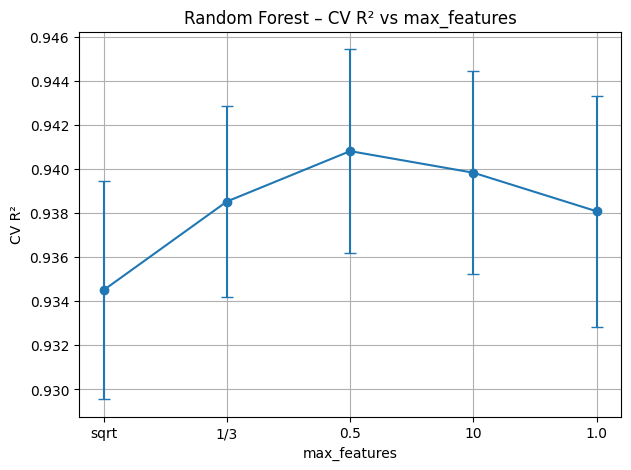

In [109]:
#r2 según max features

features = ["sqrt", 1/3, 0.5, 10, 1.0]
x_pos = np.arange(len(features))

mean_r2, std_r2 = [], []

pipe_rf.set_params(
    model__n_estimators=300,
    model__max_depth=15,
    model__min_samples_leaf=1)

for f in features:
    pipe_rf.set_params(model__max_features=f)
    scores = cross_val_score(
        pipe_rf, X_train, y_train,
        cv=cv, scoring="r2", n_jobs=-1)
    mean_r2.append(scores.mean())
    std_r2.append(scores.std())

plt.figure(figsize=(7,5))
plt.errorbar(x_pos, mean_r2, yerr=std_r2, marker="o", capsize=4)
plt.xticks(x_pos, ["sqrt", "1/3", "0.5", "10", "1.0"])
plt.xlabel("max_features")
plt.ylabel("CV R²")
plt.title("Random Forest – CV R² vs max_features")
plt.grid(True)
plt.show()

In [110]:
#error segun max features
mean_rmse, std_rmse = [], []

for f in features:
    pipe_rf.set_params(model__max_features=f)
    scores = cross_val_score(
        pipe_rf, X_train, y_train,
        cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1)
    rmse = -scores
    mean_rmse.append(rmse.mean())
    std_rmse.append(rmse.std())

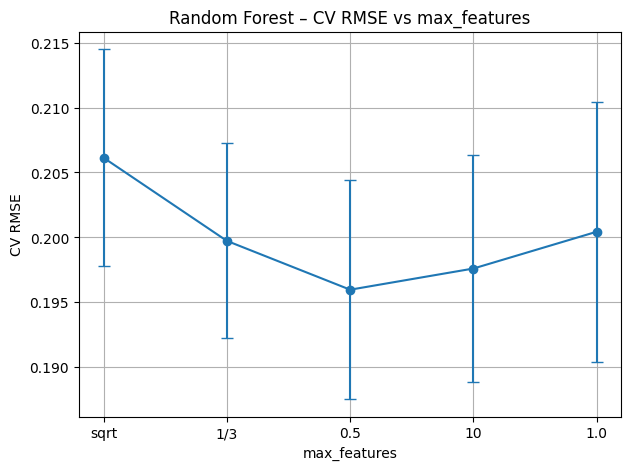

In [111]:

plt.figure(figsize=(7,5))
plt.errorbar(x_pos, mean_rmse, yerr=std_rmse, marker="o", capsize=4)
plt.xticks(x_pos, ["sqrt", "1/3", "0.5", "10", "1.0"])
plt.xlabel("max_features")
plt.ylabel("CV RMSE")
plt.title("Random Forest – CV RMSE vs max_features")
plt.grid(True)
plt.show()

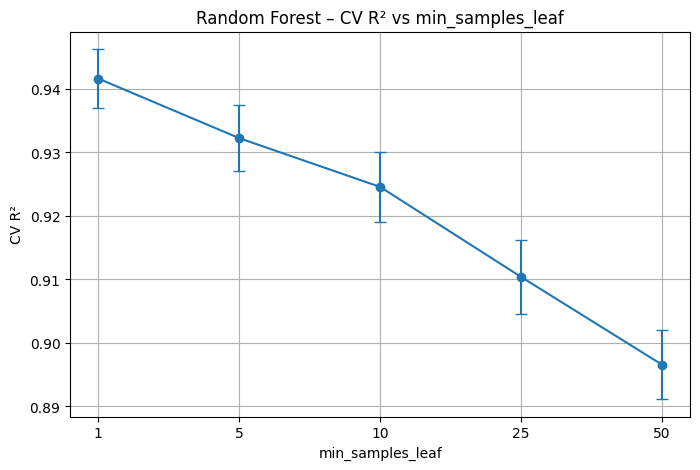

In [112]:
# min_samples_leaf – CV R2
leaf_sizes = [1, 5, 10, 25, 50]
x_pos = np.arange(len(leaf_sizes))

mean_r2 = []
std_r2 = []

# Fijamos el resto de hiperparámetros (OJO con model__)
pipe_rf.set_params(
    model__n_estimators=300,
    model__max_depth=20,
    model__max_features=0.5,)

for leaf in leaf_sizes:
    pipe_rf.set_params(model__min_samples_leaf=leaf)

    scores = cross_val_score(
        pipe_rf,
        X_train,
        y_train,
        cv=cv,
        scoring="r2",
        n_jobs=-1)

    mean_r2.append(scores.mean())
    std_r2.append(scores.std())

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x_pos, mean_r2, yerr=std_r2, marker="o", capsize=4)
plt.xticks(x_pos, [str(l) for l in leaf_sizes])
plt.xlabel("min_samples_leaf")
plt.ylabel("CV R²")
plt.title("Random Forest – CV R² vs min_samples_leaf")
plt.grid(True)
plt.show()

In [115]:
#GridSearch para parámetros óptimos
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", RandomForestRegressor(
        random_state=42,
        n_jobs=-1))])

param_grid = {
    "model__n_estimators": [250, 400, 500],
    "model__max_depth": [10, 15, 25],
    "model__min_samples_leaf": [1, 5, 10],
    "model__max_features": ["sqrt", 1/3, 0.5, 1]}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1)

grid_rf.fit(X_train, y_train)
grid_rf.best_params_

{'model__max_depth': 25,
 'model__max_features': 0.5,
 'model__min_samples_leaf': 1,
 'model__n_estimators': 500}

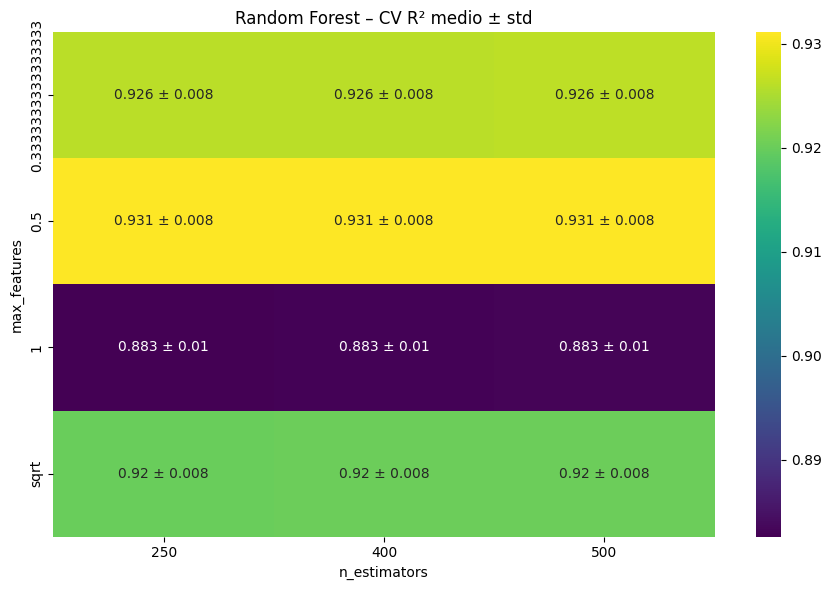

In [116]:
results = pd.DataFrame(grid_rf.cv_results_)

mean_matrix = results.pivot_table(
    index="param_model__max_features",
    columns="param_model__n_estimators",
    values="mean_test_score",
    aggfunc="mean")

std_matrix = results.pivot_table(
    index="param_model__max_features",
    columns="param_model__n_estimators",
    values="std_test_score",
    aggfunc="mean")

# Crear anotaciones tipo "0.812 ± 0.034"
annot_matrix = mean_matrix.round(3).astype(str) + " ± " + std_matrix.round(3).astype(str)

plt.figure(figsize=(9,6))
sns.heatmap(
    mean_matrix,
    annot=annot_matrix,
    fmt="",
    cmap="viridis")

plt.xlabel("n_estimators")
plt.ylabel("max_features")
plt.title("Random Forest – CV R² medio ± std")
plt.tight_layout()
plt.show()


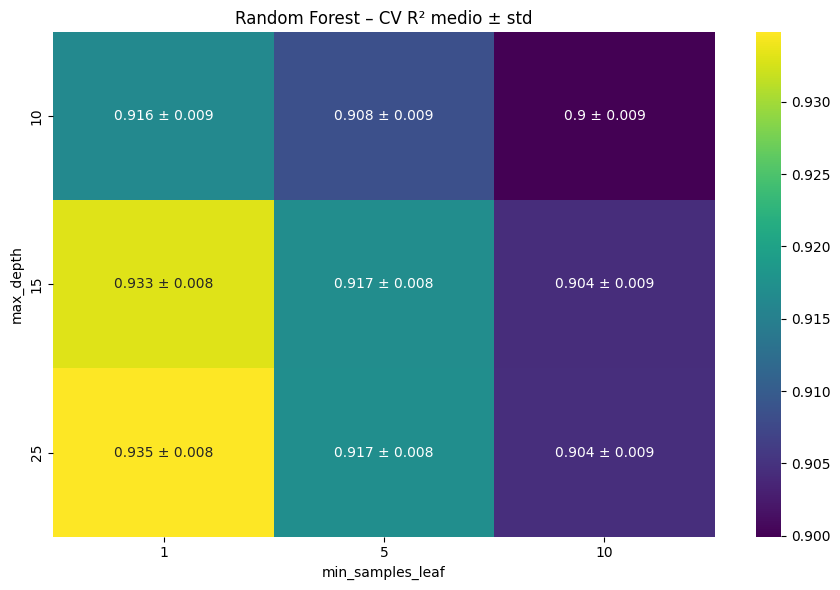

In [117]:
results = pd.DataFrame(grid_rf.cv_results_)

mean_matrix = results.pivot_table(
    index="param_model__max_depth",
    columns="param_model__min_samples_leaf",
    values="mean_test_score",
    aggfunc="mean")

std_matrix = results.pivot_table(
    index="param_model__max_depth",
    columns="param_model__min_samples_leaf",
    values="std_test_score",
    aggfunc="mean")

# Crear anotaciones tipo "0.812 ± 0.034"
annot_matrix = mean_matrix.round(3).astype(str) + " ± " + std_matrix.round(3).astype(str)

plt.figure(figsize=(9,6))
sns.heatmap(
    mean_matrix,
    annot=annot_matrix,
    fmt="",
    cmap="viridis")

plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.title("Random Forest – CV R² medio ± std")
plt.tight_layout()
plt.show()



## Modelo optimizado

In [118]:
#Modelo optimizado
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", RandomForestRegressor(
        n_estimators=500,
        max_depth=25,
        max_features=0.5,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1))])

pipe_rf.fit(X_train, y_train)

y_train_pred_rf = pipe_rf.predict(X_train)
y_test_pred_rf  = pipe_rf.predict(X_test)

print("TRAIN")
print(f"  R2:   {r2_score(y_train, y_train_pred_rf):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_rf)):.4f}")

print("\nTEST")
print(f"  R2:   {r2_score(y_test, y_test_pred_rf):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_rf)):.4f}")

TRAIN
  R2:   0.9923
  RMSE: 0.0706

TEST
  R2:   0.9458
  RMSE: 0.1866


In [119]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#R2
cv_r2_rf = cross_val_score(
    pipe_rf,
    X_train,
    y_train,
    cv=cv,
    scoring="r2")

#RMSE
cv_rmse_rf = cross_val_score(
    pipe_rf,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_root_mean_squared_error")

print(f"RF R2 CV mean: {cv_r2_rf.mean():.4f}")
print(f"RF R2 CV std:  {cv_r2_rf.std():.4f}")

print(f"RF RMSE CV mean: {-cv_rmse_rf.mean():.4f}")
print(f"RF RMSE CV std:  {cv_rmse_rf.std():.4f}")

RF R2 CV mean: 0.9414
RF R2 CV std:  0.0044
RF RMSE CV mean: 0.1949
RF RMSE CV std:  0.0080


## Modelo Heurístico

In [120]:
#Modelo heuristico
pipe_rf_heuristic = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        max_features=0.5,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1))])

pipe_rf_heuristic.fit(X_train, y_train)

y_train_pred_rf = pipe_rf_heuristic.predict(X_train)
y_test_pred_rf  = pipe_rf_heuristic.predict(X_test)

print("TRAIN")
print(f"  R2:   {r2_score(y_train, y_train_pred_rf):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_rf)):.4f}")

print("\nTEST")
print(f"  R2:   {r2_score(y_test, y_test_pred_rf):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_rf)):.4f}")

TRAIN
  R2:   0.9624
  RMSE: 0.1563

TEST
  R2:   0.9376
  RMSE: 0.2001


In [121]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#R2
cv_r2_rf = cross_val_score(
    pipe_rf_heuristic,
    X_train,
    y_train,
    cv=cv,
    scoring="r2")

#RMSE
cv_rmse_rf = cross_val_score(
    pipe_rf_heuristic,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_root_mean_squared_error")

print(f"RF R2 CV mean: {cv_r2_rf.mean():.4f}")
print(f"RF R2 CV std:  {cv_r2_rf.std():.4f}")

print(f"RF RMSE CV mean: {-cv_rmse_rf.mean():.4f}")
print(f"RF RMSE CV std:  {cv_rmse_rf.std():.4f}")

RF R2 CV mean: 0.9322
RF R2 CV std:  0.0052
RF RMSE CV mean: 0.2097
RF RMSE CV std:  0.0094


## Importancia de variables

In [122]:
feature_names = preprocess_tree.get_feature_names_out()

importances = pipe_rf.named_steps["model"].feature_importances_

importance_df = pd.DataFrame({
    "Variable": feature_names,
    "Importance": importances}).sort_values(by="Importance", ascending=False)

importance_df.head(15)

,Variable,Importance
0,num__log_surface,0.424705
2,num__Bathrooms,0.222107
4,num__Latitude,0.180996
5,num__Longitude,0.067797
1,num__Rooms,0.037738
6,bin__Elevator,0.023129
3,num__Floor,0.016785
7,bin__Air_Conditioner,0.009826
8,bin__Heater,0.005482
10,bin__Balcony,0.003918


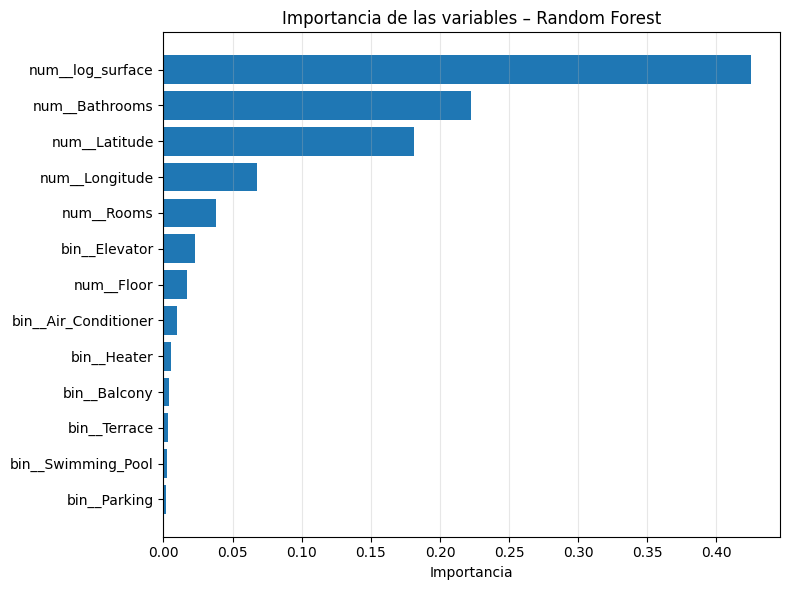

In [123]:
# Extraer nombres de variables tras el preprocesado
feature_names = (
    pipe_rf
    .named_steps["preprocess"]
    .get_feature_names_out())

# Extraer importancias del Random Forest
importances = pipe_rf.named_steps["model"].feature_importances_

# DataFrame de importancias
importance_df = (
    pd.DataFrame({
        "Variable": feature_names,
        "Importancia": importances})
    .sort_values("Importancia", ascending=False))

# Gráfico
plt.figure(figsize=(8, 6))
plt.barh(
    importance_df["Variable"],
    importance_df["Importancia"])
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.title("Importancia de las variables – Random Forest")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

## Modelo reducido

In [124]:
#Variables usadas
top_vars_clean = ['log_surface', 'Latitude', 'Bathrooms', 'Longitude']

In [125]:
preprocess_rf_reduced = ColumnTransformer(
    transformers=[
        ("num", "passthrough", top_vars_clean)])

In [126]:
#Modelo optimizado
pipe_rf_reduced = Pipeline(steps=[
    ("preprocess", preprocess_rf_reduced),
    ("model", RandomForestRegressor(
        n_estimators=500,
        max_depth=25,
        max_features=0.5,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1))])

pipe_rf_reduced.fit(X_train, y_train)

y_train_pred_rf = pipe_rf_reduced.predict(X_train)
y_test_pred_rf  = pipe_rf_reduced.predict(X_test)

print("TRAIN")
print(f"  R2:   {r2_score(y_train, y_train_pred_rf):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_rf)):.4f}")

print("\nTEST")
print(f"  R2:   {r2_score(y_test, y_test_pred_rf):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_rf)):.4f}")

TRAIN
  R2:   0.9912
  RMSE: 0.0757

TEST
  R2:   0.9373
  RMSE: 0.2006


In [127]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#R2
cv_r2_rf = cross_val_score(
    pipe_rf_reduced,
    X_train,
    y_train,
    cv=cv,
    scoring="r2")

#RMSE
cv_rmse_rf = cross_val_score(
    pipe_rf_reduced,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_root_mean_squared_error")

print(f"RF R2 CV mean: {cv_r2_rf.mean():.4f}")
print(f"RF R2 CV std:  {cv_r2_rf.std():.4f}")

print(f"RF RMSE CV mean: {-cv_rmse_rf.mean():.4f}")
print(f"RF RMSE CV std:  {cv_rmse_rf.std():.4f}")

RF R2 CV mean: 0.9327
RF R2 CV std:  0.0055
RF RMSE CV mean: 0.2089
RF RMSE CV std:  0.0095


## XGBoost

In [128]:
pipe_xgb = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", xgb.XGBRegressor(
        n_estimators=300,
        max_depth=None,
        objective="reg:squarederror",
        random_state=42))])

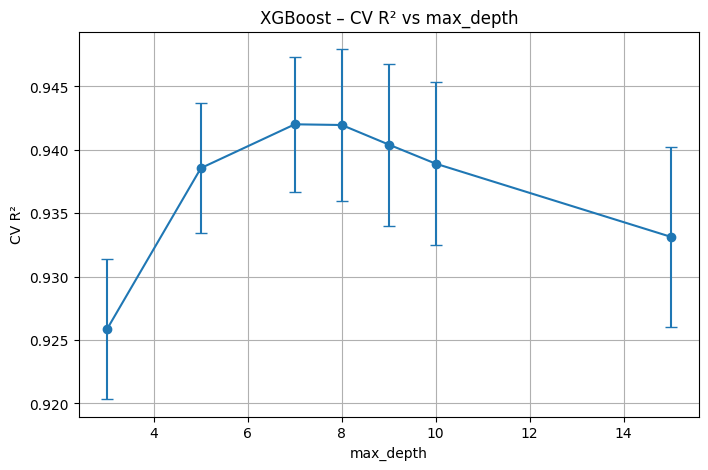

In [129]:
depths = [3, 5, 7, 8, 9, 10, 15]
mean_r2, std_r2 = [], []

pipe_xgb.set_params(
    model__learning_rate=0.05,
    model__n_estimators=300)

for d in depths:
    pipe_xgb.set_params(model__max_depth=d)
    scores = cross_val_score(
        pipe_xgb, X_train, y_train,
        cv=cv, scoring="r2", n_jobs=-1)
    mean_r2.append(scores.mean())
    std_r2.append(scores.std())

plt.figure(figsize=(8,5))
plt.errorbar(depths, mean_r2, yerr=std_r2, marker="o", capsize=4)
plt.xlabel("max_depth")
plt.ylabel("CV R²")
plt.title("XGBoost – CV R² vs max_depth")
plt.grid(True)
plt.show()

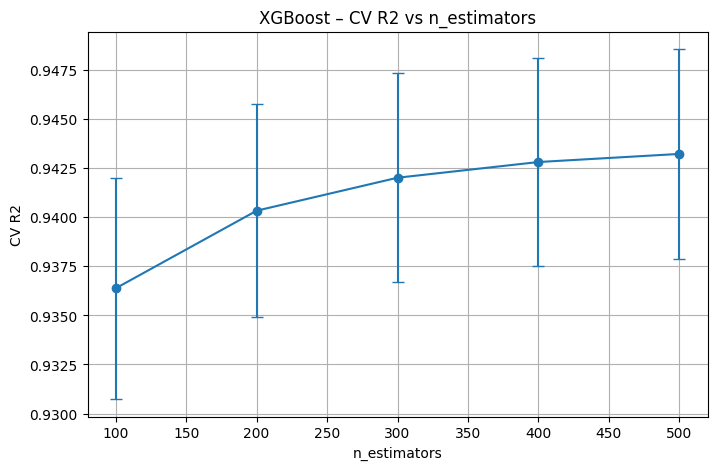

In [130]:
mean_rmse, std_rmse = [], []
pipe_xgb.set_params(
    model__learning_rate=0.05,
    model__max_depth=7)

for n in [100, 200, 300, 400, 500]:
    pipe_xgb.set_params(model__n_estimators=n)
    scores = cross_val_score(
        pipe_xgb, X_train, y_train,
        cv=cv, scoring="r2",
        n_jobs=-1)
    rmse = scores
    mean_rmse.append(rmse.mean())
    std_rmse.append(rmse.std())

plt.figure(figsize=(8,5))
plt.errorbar([100,200,300,400,500], mean_rmse, yerr=std_rmse, marker="o", capsize=4)
plt.xlabel("n_estimators")
plt.ylabel("CV R2")
plt.title("XGBoost – CV R2 vs n_estimators")
plt.grid(True)
plt.show()

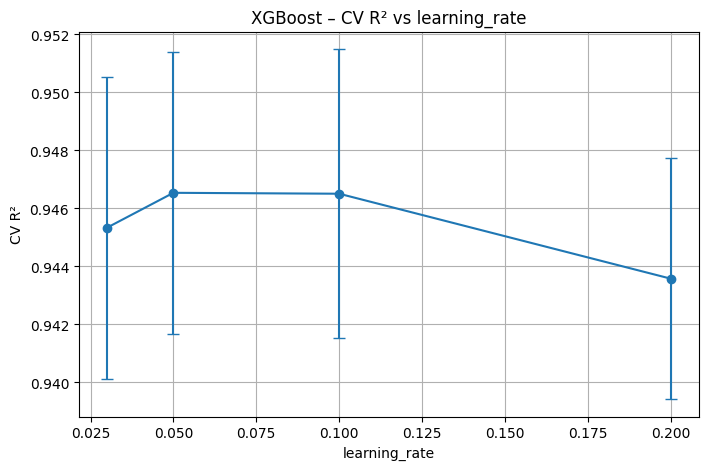

In [131]:
# learning_rate – CV R2
learning_rates = [0.03, 0.05, 0.1, 0.2]

mean_r2, std_r2 = [], []

pipe_xgb.set_params(
    model__n_estimators=300,
    model__max_depth=7,
    model__subsample=0.8,
    model__colsample_bytree=0.8)

for lr in learning_rates:
    pipe_xgb.set_params(model__learning_rate=lr)

    scores = cross_val_score(
        pipe_xgb,
        X_train,
        y_train,
        cv=cv,
        scoring="r2",
        n_jobs=-1)

    mean_r2.append(scores.mean())
    std_r2.append(scores.std())

plt.figure(figsize=(8, 5))
plt.errorbar(learning_rates, mean_r2, yerr=std_r2, marker="o", capsize=4)
plt.xlabel("learning_rate")
plt.ylabel("CV R²")
plt.title("XGBoost – CV R² vs learning_rate")
plt.grid(True)
plt.show()

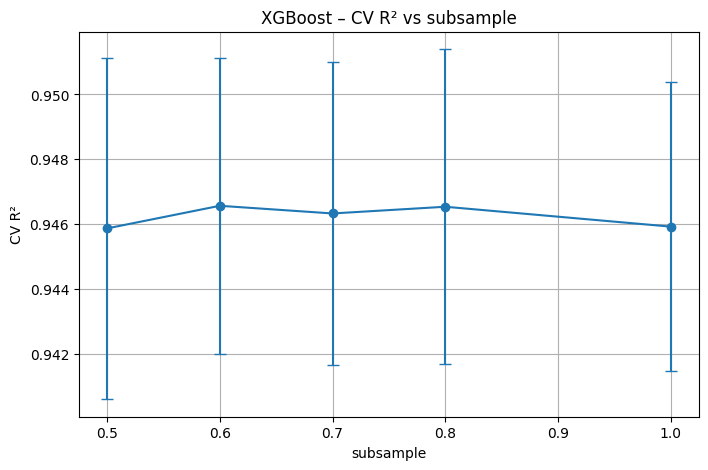

In [132]:
# subsample – CV R2
subsamples = [0.5, 0.6, 0.7, 0.8, 1.0]

mean_r2, std_r2 = [], []

pipe_xgb.set_params(
    model__n_estimators=300,
    model__max_depth=7,
    model__learning_rate=0.05,
    model__colsample_bytree=0.8)

for sub in subsamples:
    pipe_xgb.set_params(model__subsample=sub)

    scores = cross_val_score(
        pipe_xgb,
        X_train,
        y_train,
        cv=cv,
        scoring="r2",
        n_jobs=-1)

    mean_r2.append(scores.mean())
    std_r2.append(scores.std())

plt.figure(figsize=(8, 5))
plt.errorbar(subsamples, mean_r2, yerr=std_r2, marker="o", capsize=4)
plt.xlabel("subsample")
plt.ylabel("CV R²")
plt.title("XGBoost – CV R² vs subsample")
plt.grid(True)
plt.show()

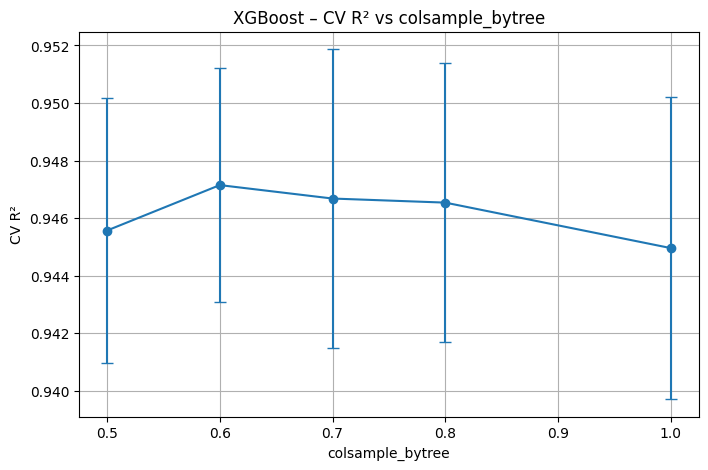

In [133]:
# colsample_bytree – CV R2
colsamples = [0.5, 0.6, 0.7, 0.8, 1.0]

mean_r2, std_r2 = [], []

pipe_xgb.set_params(
    model__n_estimators=300,
    model__max_depth=7,
    model__learning_rate=0.05,
    model__subsample=0.8)

for col in colsamples:
    pipe_xgb.set_params(model__colsample_bytree=col)

    scores = cross_val_score(
        pipe_xgb,
        X_train,
        y_train,
        cv=cv,
        scoring="r2",
        n_jobs=-1)

    mean_r2.append(scores.mean())
    std_r2.append(scores.std())

plt.figure(figsize=(8, 5))
plt.errorbar(colsamples, mean_r2, yerr=std_r2, marker="o", capsize=4)
plt.xlabel("colsample_bytree")
plt.ylabel("CV R²")
plt.title("XGBoost – CV R² vs colsample_bytree")
plt.grid(True)
plt.show()

## Modelo óptimo

In [134]:
param_grid = {
    "model__n_estimators": [200, 300, 500],
    "model__max_depth": [5, 7, 10],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0]}

grid_xgb = GridSearchCV(
    pipe_xgb,
    param_grid,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1)

grid_xgb.fit(X_train, y_train)

grid_xgb.best_params_

{'model__colsample_bytree': 0.6,
 'model__learning_rate': 0.05,
 'model__max_depth': 7,
 'model__n_estimators': 500,
 'model__subsample': 0.8}

In [135]:
pipe_xgb = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", xgb.XGBRegressor(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.6,
        objective="reg:squarederror",
        random_state=42))])

pipe_xgb.fit(X_train, y_train)

y_train_pred_xgb = pipe_xgb.predict(X_train)
y_test_pred_xgb  = pipe_xgb.predict(X_test)

print("TRAIN")
print(f" R2:   {r2_score(y_train, y_train_pred_xgb):.4f}")
print(f" RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_xgb)):.4f}")

print("\nTEST")
print(f" R2:   {r2_score(y_test, y_test_pred_xgb):.4f}")
print(f" RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)):.4f}")

TRAIN
 R2:   0.9904
 RMSE: 0.0790

TEST
 R2:   0.9500
 RMSE: 0.1791


In [136]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2_xgb = cross_val_score(
    pipe_xgb,
    X_train,
    y_train,
    cv=cv,
    scoring="r2")

cv_rmse_xgb = cross_val_score(
    pipe_xgb,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_root_mean_squared_error")

print(f"XGB R2 CV mean: {cv_r2_xgb.mean():.4f}")
print(f"XGB R2 CV std:  {cv_r2_xgb.std():.4f}")

print(f"XGB RMSE CV mean: {-cv_rmse_xgb.mean():.4f}")
print(f"XGB RMSE CV std:  {cv_rmse_xgb.std():.4f}")

XGB R2 CV mean: 0.9482
XGB R2 CV std:  0.0038
XGB RMSE CV mean: 0.1833
XGB RMSE CV std:  0.0073


## Modelo Heurístico

In [137]:
pipe_xgb_heuristic = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", xgb.XGBRegressor(
        n_estimators=300,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs = 1))])

pipe_xgb_heuristic.fit(X_train, y_train)

y_train_pred_xgb = pipe_xgb_heuristic.predict(X_train)
y_test_pred_xgb  = pipe_xgb_heuristic.predict(X_test)

print("TRAIN")
print(f" R2:   {r2_score(y_train, y_train_pred_xgb):.4f}")
print(f" RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_xgb)):.4f}")

print("\nTEST")
print(f" R2:   {r2_score(y_test, y_test_pred_xgb):.4f}")
print(f" RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)):.4f}")

TRAIN
 R2:   0.9859
 RMSE: 0.0957

TEST
 R2:   0.9492
 RMSE: 0.1806


In [138]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2_xgb = cross_val_score(
    pipe_xgb_heuristic,
    X_train,
    y_train,
    cv=cv,
    scoring="r2")

cv_rmse_xgb = cross_val_score(
    pipe_xgb_heuristic,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_root_mean_squared_error")

print(f"XGB R2 CV mean: {cv_r2_xgb.mean():.4f}")
print(f"XGB R2 CV std:  {cv_r2_xgb.std():.4f}")

print(f"XGB RMSE CV mean: {-cv_rmse_xgb.mean():.4f}")
print(f"XGB RMSE CV std:  {cv_rmse_xgb.std():.4f}")

XGB R2 CV mean: 0.9465
XGB R2 CV std:  0.0049
XGB RMSE CV mean: 0.1862
XGB RMSE CV std:  0.0095


In [139]:
#Exportar modelo para web
#import joblib
#Guardar el pipeline completo (preprocesado + modelo)
#joblib.dump(pipe_xgb, "modelo_xgb_final.pkl")
#from google.colab import files
#files.download("modelo_xgb_final.pkl")

## Importancia de variables

In [140]:
feature_names = preprocess_tree.get_feature_names_out()

importances_xgb = pipe_xgb.named_steps["model"].feature_importances_

importance_xgb_df = (
    pd.DataFrame({
        "Variable": feature_names,
        "Importance": importances_xgb})
    .sort_values(by="Importance", ascending=False))

importance_xgb_df.head(20)

,Variable,Importance
2,num__Bathrooms,0.411784
0,num__log_surface,0.154809
4,num__Latitude,0.086641
6,bin__Elevator,0.079328
1,num__Rooms,0.077364
5,num__Longitude,0.040388
7,bin__Air_Conditioner,0.039866
8,bin__Heater,0.028833
12,bin__Swimming_Pool,0.022230
10,bin__Balcony,0.017282


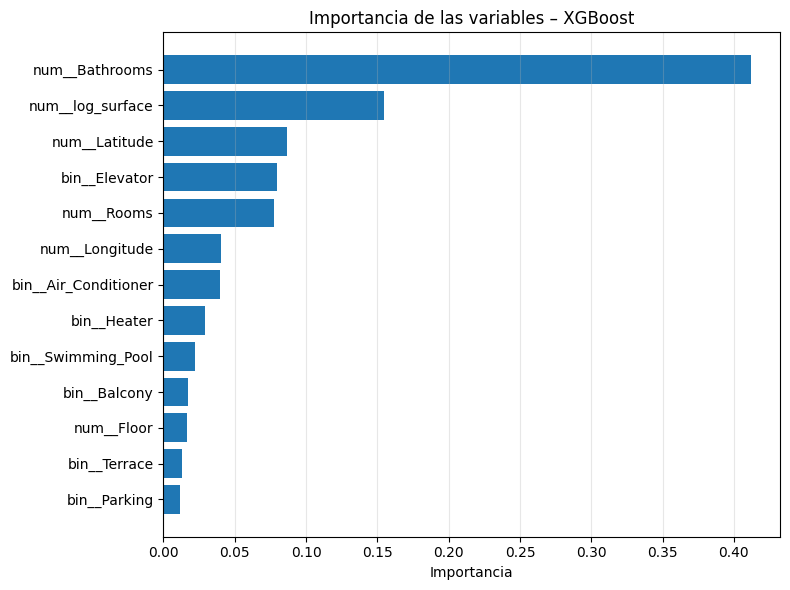

In [141]:
# Extraer nombres de variables tras el preprocesado
feature_names = (
    pipe_xgb
    .named_steps["preprocess"]
    .get_feature_names_out())

# Extraer importancias del modelo XGBoost
importances = pipe_xgb.named_steps["model"].feature_importances_

# DataFrame de importancias
importance_df_xgb = (
    pd.DataFrame({
        "Variable": feature_names,
        "Importancia": importances})
    .sort_values("Importancia", ascending=False))

# (Opcional) quedarte solo con las top variables
top_n = 15
importance_df_xgb_top = importance_df_xgb.head(top_n)

# Gráfico
plt.figure(figsize=(8, 6))
plt.barh(
    importance_df_xgb_top["Variable"],
    importance_df_xgb_top["Importancia"])
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.title("Importancia de las variables – XGBoost")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# Modelo reducido

In [142]:
# Seleccionar top k variables por importancia
top_k = 5
top_vars = importance_xgb_df.head(top_k)["Variable"].tolist()

top_vars

# Quitar prefijos num__ y bin__
top_vars_clean = [v.split("__")[1] for v in top_vars]
top_vars_clean

# Detectar cuáles son numéricas y binarias
top_num_vars = [v for v in top_vars_clean if v in num_vars]
top_bin_vars = [v for v in top_vars_clean if v in bin_vars]

preprocess_xgb_reduced = ColumnTransformer(
    transformers=[
        ("num", "passthrough", top_num_vars),
        ("bin", "passthrough", top_bin_vars)])

In [143]:
pipe_xgb_reduced = Pipeline(steps=[
    ("preprocess", preprocess_xgb_reduced),
    ("model", xgb.XGBRegressor(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.6,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=1))])

In [144]:
pipe_xgb_reduced.fit(X_train, y_train)

y_train_pred_xgb_red = pipe_xgb_reduced.predict(X_train)
y_test_pred_xgb_red  = pipe_xgb_reduced.predict(X_test)

print("XGBoost – VARIABLES REDUCIDAS")
print("TRAIN")
print(f"R2:   {r2_score(y_train, y_train_pred_xgb_red):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_xgb_red)):.4f}")

print("\nTEST")
print(f"R2:   {r2_score(y_test, y_test_pred_xgb_red):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_xgb_red)):.4f}")


XGBoost – VARIABLES REDUCIDAS
TRAIN
R2:   0.9561
RMSE: 0.1689

TEST
R2:   0.9001
RMSE: 0.2532


In [145]:
cv_results_xgb_red = cross_validate(
    pipe_xgb_reduced,
    X_train,
    y_train,
    cv=cv,
    scoring=["r2", "neg_root_mean_squared_error"],
    n_jobs=1)

print("\nCV – XGBoost reducido")
print(f"R2 CV mean: {cv_results_xgb_red['test_r2'].mean():.4f}")
print(f"R2 CV std:  {cv_results_xgb_red['test_r2'].std():.4f}")
print(f"RMSE CV mean: {-cv_results_xgb_red['test_neg_root_mean_squared_error'].mean():.4f}")
print(f"RMSE CV std:  {cv_results_xgb_red['test_neg_root_mean_squared_error'].std():.4f}")


CV – XGBoost reducido
R2 CV mean: 0.8987
R2 CV std:  0.0052
RMSE CV mean: 0.2564
RMSE CV std:  0.0073


# SVR

In [146]:
pipe_svr = Pipeline(steps=[
    ("preprocess", preprocess_scaled),
    ("model", SVR(kernel="rbf"))])

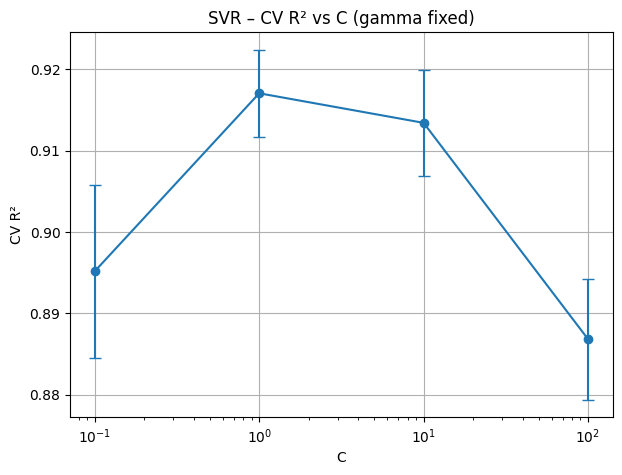

In [147]:
C_values = [0.1, 1, 10, 100] #Con 1000 ya baja muchisimo el r2
mean_r2, std_r2 = [], []

# fijamos gamma
pipe_svr.set_params(model__gamma="scale")

for C in C_values:
    pipe_svr.set_params(model__C=C)

    scores = cross_val_score(
        pipe_svr,
        X_train,
        y_train,
        cv=cv,
        scoring="r2",
        n_jobs=-1)

    mean_r2.append(scores.mean())
    std_r2.append(scores.std())

plt.figure(figsize=(7,5))
plt.errorbar(C_values, mean_r2, yerr=std_r2, marker="o", capsize=4)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("CV R²")
plt.title("SVR – CV R² vs C (gamma fixed)")
plt.grid(True)
plt.show()


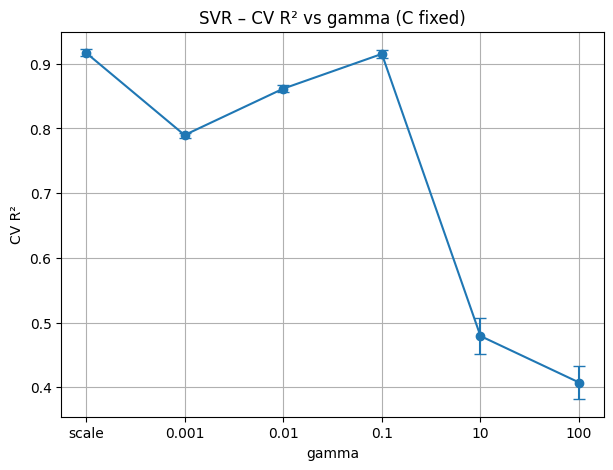

In [148]:
gamma_values = ["scale", 0.001, 0.01, 0.1, 10, 100] #Con 100 y 1000 baja mucho r2
mean_r2, std_r2 = [], []

# fijamos C
pipe_svr.set_params(model__C=1)

for g in gamma_values:
    pipe_svr.set_params(model__gamma=g)

    scores = cross_val_score(
        pipe_svr,
        X_train,
        y_train,
        cv=cv,
        scoring="r2",
        n_jobs=-1)

    mean_r2.append(scores.mean())
    std_r2.append(scores.std())

plt.figure(figsize=(7,5))
plt.errorbar(range(len(gamma_values)), mean_r2, yerr=std_r2, marker="o", capsize=4)
plt.xticks(range(len(gamma_values)), gamma_values)
plt.xlabel("gamma")
plt.ylabel("CV R²")
plt.title("SVR – CV R² vs gamma (C fixed)")
plt.grid(True)
plt.show()


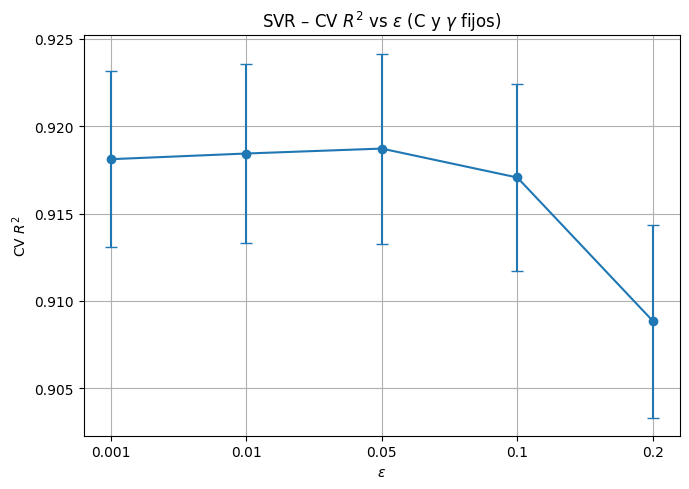

In [149]:
# Valores de epsilon a probar
epsilon_values = [0.001, 0.01, 0.05, 0.1, 0.2]

mean_r2, std_r2 = [], []

# Fijamos C y gamma
pipe_svr.set_params(
    model__C=1,
    model__gamma="scale")

for eps in epsilon_values:
    pipe_svr.set_params(model__epsilon=eps)

    scores = cross_val_score(
        pipe_svr,
        X_train,
        y_train,
        cv=cv,
        scoring="r2",
        n_jobs=-1)

    mean_r2.append(scores.mean())
    std_r2.append(scores.std())

# Gráfico
plt.figure(figsize=(7, 5))
plt.errorbar(
    range(len(epsilon_values)),
    mean_r2,
    yerr=std_r2,
    marker="o",
    capsize=4)
plt.xticks(range(len(epsilon_values)), epsilon_values)
plt.xlabel(r"$\epsilon$")
plt.ylabel("CV $R^2$")
plt.title(r"SVR – CV $R^2$ vs $\epsilon$ (C y $\gamma$ fijos)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Modelo optimizado

In [150]:
param_grid = {
    "model__C": [0.1, 1, 10, 100],
    "model__gamma": ["scale", 0.01, 0.1, 1, 10, 100],
    "model__epsilon": [0.001, 0.01, 0.05, 0.1]}

grid_svr = GridSearchCV(
    pipe_svr,
    param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1)

grid_svr.fit(X_train, y_train)

grid_svr.best_params_


{'model__C': 1, 'model__epsilon': 0.05, 'model__gamma': 'scale'}

In [151]:
pipe_svr.set_params(
    model__C=1,
    model__gamma="scale",
    model__epsilon=0.05)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['log_surface', 'Rooms',
                                                   'Bathrooms', 'Floor',
                                                   'Latitude', 'Longitude']),
                                                 ('bin', 'passthrough',
                                                  ['Elevator',
                                                   'Air_Conditioner', 'Heater',
                                                   'Parking', 'Balcony',
                                                   'Terrace',
                                                   'Swimming_Pool'])])),
                ('model', SVR(C=1, epsilon=0.05))])

In [152]:
pipe_svr.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['log_surface', 'Rooms',
                                                   'Bathrooms', 'Floor',
                                                   'Latitude', 'Longitude']),
                                                 ('bin', 'passthrough',
                                                  ['Elevator',
                                                   'Air_Conditioner', 'Heater',
                                                   'Parking', 'Balcony',
                                                   'Terrace',
                                                   'Swimming_Pool'])])),
                ('model', SVR(C=1, epsilon=0.05))])

In [153]:
# Predicciones
y_train_pred = pipe_svr.predict(X_train)
y_test_pred  = pipe_svr.predict(X_test)

# Métricas
train_r2   = r2_score(y_train, y_train_pred)
test_r2    = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("SVR Performance")
print(f"Train R2: {train_r2:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

SVR Performance
Train R2: 0.9394
Test R2: 0.9199
Train RMSE: 0.1985
Test RMSE: 0.2267


Validacion Cruzada

In [154]:
cv_r2_svr = cross_val_score(
    pipe_svr,
    X_train,
    y_train,
    cv=cv,
    scoring="r2",
    n_jobs=-1)

print("SVR Cross-validation (R2)")
print(f"CV R2 mean: {cv_r2_svr.mean():.4f}")
print(f"CV R2 std: {cv_r2_svr.std():.4f}")

SVR Cross-validation (R2)
CV R2 mean: 0.9187
CV R2 std: 0.0054


In [155]:
cv_rmse_svr = cross_val_score(
    pipe_svr,
    X_train,
    y_train,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1)

cv_rmse_svr = -cv_rmse_svr

print("SVR Cross-validation (RMSE)")
print(f"CV RMSE mean: {cv_rmse_svr.mean():.4f}")
print(f"CV RMSE std: {cv_rmse_svr.std():.4f}")

SVR Cross-validation (RMSE)
CV RMSE mean: 0.2297
CV RMSE std: 0.0095
